# **Anomaly Detection and Time-Series Analysis for Supplier Service Volumes and Charges**

## **Introduction**
This notebook explores the temporal patterns and correlations between supplier service volumes and Medicare payments, with a focus on identifying inefficiencies or anomalies in the data. The goal is to use **anomaly detection** models to uncover periods of unusual behavior that could suggest inefficiencies or potential fraud. The analysis employs **Isolation Forest** and **Local Outlier Factor** (LOF) models, which are effective for detecting anomalies in high-dimensional datasets.

## **Unsupervised Classification Overview**
Unsupervised classification, unlike supervised classification, does not rely on labeled data to learn the patterns or relationships in the data. Instead, it identifies inherent structures within the data without predefined categories.

### Feature Selection Using PCA:
To reduce dimensionality and focus on the most relevant features for classification, **Principal Component Analysis (PCA)** is performed. PCA reduces the number of features while retaining the most significant variance in the data. The selected features for classification include:
- `Tot_Suplrs`: Total number of suppliers
- `Tot_Suplr_Benes`: Total number of beneficiaries
- `Tot_Suplr_Srvcs`: Total number of services provided by suppliers
- `Avg_Suplr_Sbmtd_Chrg`: Average supplier submitted charges
- `Avg_Suplr_Mdcr_Alowd_Amt`: Average Medicare allowed amount
- `Avg_Suplr_Mdcr_Pymt_Amt`: Average Medicare payment amount

These features were selected for their contribution to explaining the variance in the dataset and for improving model efficiency and stability by reducing overfitting.

### Models Used:
1. **Isolation Forest**:
  The Isolation Forest algorithm helps identify anomalies by isolating data points that deviate from the majority. It isolates outliers by constructing multiple trees where those anomalies are easier to isolate due to their distance from the majority of the data points.

2. **Local Outlier Factor (LOF)**:
   LOF detects anomalies by measuring the local density deviation of a data point with respect to its neighbors. Points with significantly lower density compared to their neighbors are flagged as anomalies. LOF is more sensitive to local changes and can detect anomalies in regions where the overall distribution of data is uneven.

#### **Comparison and Selection**:
The winner between **Isolation Forest** and **LOF** will be selected based on their ability to identify meaningful anomalies in the supplier behavior data. The selected model will be used to detect outliers and remove them from the dataset, ensuring cleaner data for subsequent analysis. By removing these outliers, we can ensure that the models used in the following analysis are more robust and less likely to be skewed by extreme values.

#### **Modeling Steps**:
1. **Train both models**: Fit both Isolation Forest and LOF models to the data.
2. **Evaluate performance**: Compare their ability to identify anomalies based on the outlier rates and their impact on the overall dataset.
3. **Select the best model**: Choose the model that performs better in terms of outlier detection and anomaly identification.
4. **Remove detected anomalies**: Use the selected model to flag and remove the anomalies from the dataset for cleaner, more reliable analysis.

By applying these techniques, we ensure that only meaningful data is used for further modeling, improving the accuracy and interpretability of the subsequent analyses.

## **Research Question**
**RQ1**: *How do correlations between service volumes and supplier charges evolve over time, and what temporal patterns suggest inefficiencies?*

The aim is to explore how anomalies in service volumes and supplier charges can indicate periods of inefficiency, potential fraud, or other factors that might require targeted intervention.

### **Goals**:
- Identify temporal patterns in service volumes and supplier charges.
- Detect outliers in the data that may indicate inefficiencies or anomalies.
- Understand how anomalies evolve over time and across different regions.
- Use anomaly detection models (Isolation Forest and LOF) to remove outliers and clean the data for further analysis.

### **Time-Series Split Cross-Validation**:
Since the data is temporal, we apply **TimeSeriesSplit** to ensure that each model is trained on past data and tested on future data, avoiding data leakage. This method allows us to better assess how the models perform on unseen data, which is crucial for ensuring the robustness and reliability of the analysis.

### **Model Comparison**:
- **Isolation Forest vs. LOF**: By comparing the two models, we aim to identify which is better suited for anomaly detection in this context. The best-performing model will be used to flag anomalies and clean the dataset.
- **Evaluation**: Metrics like the **outlier rate** (percentage of anomalies detected) and their impact on model performance will be evaluated.

### **Conclusion**:
This notebook aims to identify temporal anomalies in supplier service volumes and charges, helping to uncover inefficiencies, potential fraud, or areas that need targeted intervention. By comparing **Isolation Forest** and **LOF** models, the notebook ensures that only the best model is used for detecting and removing anomalies from the data, thereby improving the accuracy of subsequent analyses.

With the selected anomaly detection model, we will proceed to explore the relationships between service volumes and supplier charges, ultimately contributing to a deeper understanding of inefficiencies in the Medicare DMEPOS system.


In [1]:
import os

# Set the working directory to the folder
os.chdir('/Users/rozani/Desktop/capstone')

In [2]:
# Suppress warnings during execution
import warnings
warnings.filterwarnings("ignore")

# Importing essential libraries for data handling, modeling, and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Anomaly detection and model evaluation tools
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Load the training data
train_data = pd.read_csv('combined_data.csv')
print(train_data.columns)

# Load the test data
test_data = pd.read_csv('test_data.csv')
print(test_data.columns)


Index(['Rfrg_Prvdr_Geo_Lvl', 'Rfrg_Prvdr_Geo_Cd', 'Rfrg_Prvdr_Geo_Desc',
       'RBCS_Lvl', 'RBCS_Id', 'RBCS_Desc', 'HCPCS_Cd', 'HCPCS_Desc',
       'Suplr_Rentl_Ind', 'Tot_Rfrg_Prvdrs', 'Tot_Suplrs', 'Tot_Suplr_Benes',
       'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg',
       'Avg_Suplr_Mdcr_Alowd_Amt', 'Avg_Suplr_Mdcr_Pymt_Amt',
       'Avg_Suplr_Mdcr_Stdzd_Amt', 'Year', 'high_charges',
       'low_service_volumes', 'is_underserved', 'underserved_level'],
      dtype='object')
Index(['Rfrg_Prvdr_Geo_Lvl', 'Rfrg_Prvdr_Geo_Cd', 'Rfrg_Prvdr_Geo_Desc',
       'RBCS_Lvl', 'RBCS_Id', 'RBCS_Desc', 'HCPCS_Cd', 'HCPCS_Desc',
       'Suplr_Rentl_Ind', 'Tot_Rfrg_Prvdrs', 'Tot_Suplrs', 'Tot_Suplr_Benes',
       'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg',
       'Avg_Suplr_Mdcr_Alowd_Amt', 'Avg_Suplr_Mdcr_Pymt_Amt',
       'Avg_Suplr_Mdcr_Stdzd_Amt', 'Year', 'high_charges',
       'low_service_volumes', 'is_underserved', 'underserved_level'],
      dtype='object'

### Feature Selection, Scaling, and Model Setup for Anomaly Detection with Training Data

In [4]:
# Define features and scale them
features = ['Tot_Suplrs', 'Tot_Suplr_Benes', 'Tot_Suplr_Srvcs', 
            'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt', 
            'Avg_Suplr_Mdcr_Pymt_Amt']
X = train_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize models
isf_model = IsolationForest(contamination=0.05, random_state=42)
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Track results
comparison_results = []

# Loop through cross-validation splits
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    
    # Train models and get outlier rates
    isf_model.fit(X_train)
    isf_preds = isf_model.predict(X_test)
    isf_outlier_rate = (isf_preds == -1).mean()
    
    lof_preds = lof_model.fit_predict(X_test)
    lof_outlier_rate = (lof_preds == -1).mean()

    # Store results
    comparison_results.append({
        'Fold': len(comparison_results) + 1,
        'ISF Outlier Rate': isf_outlier_rate,
        'LOF Outlier Rate': lof_outlier_rate
    })

# Convert to DataFrame and display
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

# Calculate average outlier rates
avg_outlier_rate_isf = comparison_df['ISF Outlier Rate'].mean()
avg_outlier_rate_lof = comparison_df['LOF Outlier Rate'].mean()

# Print results and select the better model
print(f"Avg Outlier Rate - ISF: {avg_outlier_rate_isf}")
print(f"Avg Outlier Rate - LOF: {avg_outlier_rate_lof}")
best_model = isf_model if avg_outlier_rate_isf < avg_outlier_rate_lof else lof_model
print("Best Model:", "Isolation Forest" if best_model == isf_model else "LOF")

   Fold  ISF Outlier Rate  LOF Outlier Rate
0     1          0.056716          0.050005
1     2          0.054560          0.050005
2     3          0.050635          0.050005
3     4          0.064321          0.050005
4     5          0.048826          0.050005
Avg Outlier Rate - ISF: 0.055011692933401114
Avg Outlier Rate - LOF: 0.05000508388408744
Best Model: LOF


### Anomaly Detection with Training and Testing Data

In [5]:
# Define the features and labels for training and test data
features = ['Tot_Suplrs', 'Tot_Suplr_Benes', 'Tot_Suplr_Srvcs',
            'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt', 
            'Avg_Suplr_Mdcr_Pymt_Amt']

# Define the training and test sets separately
X_train = train_data[features]
X_test = test_data[features]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on train data
X_test_scaled = scaler.transform(X_test)  # Only transform on test data

# Define the time-series split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the models
isf_model = IsolationForest(contamination=0.05, random_state=42)
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# DataFrame to store results
comparison_results = []

# Loop through the splits
for train_index, test_index in tscv.split(X_train_scaled):
    X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    
    # Train Isolation Forest on the training fold
    isf_model.fit(X_train_fold)
    
    # Predict anomalies for Isolation Forest on the test fold
    isf_preds = isf_model.predict(X_test_fold)
    isf_outlier_rate = (isf_preds == -1).mean()
    
    # Predict anomalies for LOF on the test fold
    lof_preds = lof_model.fit_predict(X_test_fold)
    lof_outlier_rate = (lof_preds == -1).mean()

    # Store the results in the comparison_results list
    comparison_results.append({
        'Fold': len(comparison_results) + 1,
        'ISF Outlier Rate': isf_outlier_rate,
        'LOF Outlier Rate': lof_outlier_rate
    })

# Convert the results into a DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Display the comparison results
print(comparison_df)

# Calculate the average outlier rate for each model
average_outlier_rate_isf = comparison_df['ISF Outlier Rate'].mean()
average_outlier_rate_lof = comparison_df['LOF Outlier Rate'].mean()

print("Average Outlier Rate - Isolation Forest: ", average_outlier_rate_isf)
print("Average Outlier Rate - LOF: ", average_outlier_rate_lof)

# Based on the outlier rate, select the better performing model
if average_outlier_rate_isf < average_outlier_rate_lof:
    print("Isolation Forest performs better.")
    best_model = isf_model
else:
    print("LOF performs better.")
    best_model = lof_model

   Fold  ISF Outlier Rate  LOF Outlier Rate
0     1          0.056716          0.050005
1     2          0.054560          0.050005
2     3          0.050635          0.050005
3     4          0.064321          0.050005
4     5          0.048826          0.050005
Average Outlier Rate - Isolation Forest:  0.055011692933401114
Average Outlier Rate - LOF:  0.05000508388408744
LOF performs better.


### Removing Anomalies from Training Data and Saving Cleaned Dataset

In [6]:

# If the best model is LOF, use it to predict anomalies on the entire training data
if best_model == lof_model:
    # Predict anomalies on the full training data (X_train_scaled)
    lof_preds = lof_model.fit_predict(X_train_scaled)  # fit_predict returns 1 (inliers) or -1 (outliers)
    
    # Remove anomalies (outliers) from the training data
    train_data_no_anomalies = train_data[lof_preds == 1]  # Keep only inliers

# If the best model is Isolation Forest
elif best_model == isf_model:
    # Predict anomalies on the full training data (X_train_scaled)
    isf_preds = isf_model.fit_predict(X_train_scaled)  # fit_predict returns 1 (inliers) or -1 (outliers)
    
    # Remove anomalies (outliers) from the training data
    train_data_no_anomalies = train_data[isf_preds == 1]  # Keep only inliers

# Save the cleaned training data to a CSV file
output_file_path = "cleaned_data.csv"
train_data_no_anomalies.to_csv(output_file_path, index=False)

# Print the number of rows in the original and cleaned datasets
print(f"Original training data shape: {train_data.shape}")
print(f"Cleaned training data shape: {train_data_no_anomalies.shape}")
print(f"Cleaned data saved to {output_file_path}")


Original training data shape: (295052, 23)
Cleaned training data shape: (280299, 23)
Cleaned data saved to cleaned_data.csv


## Identifying and Visualizing Anomalies by Year, Region, and Feature

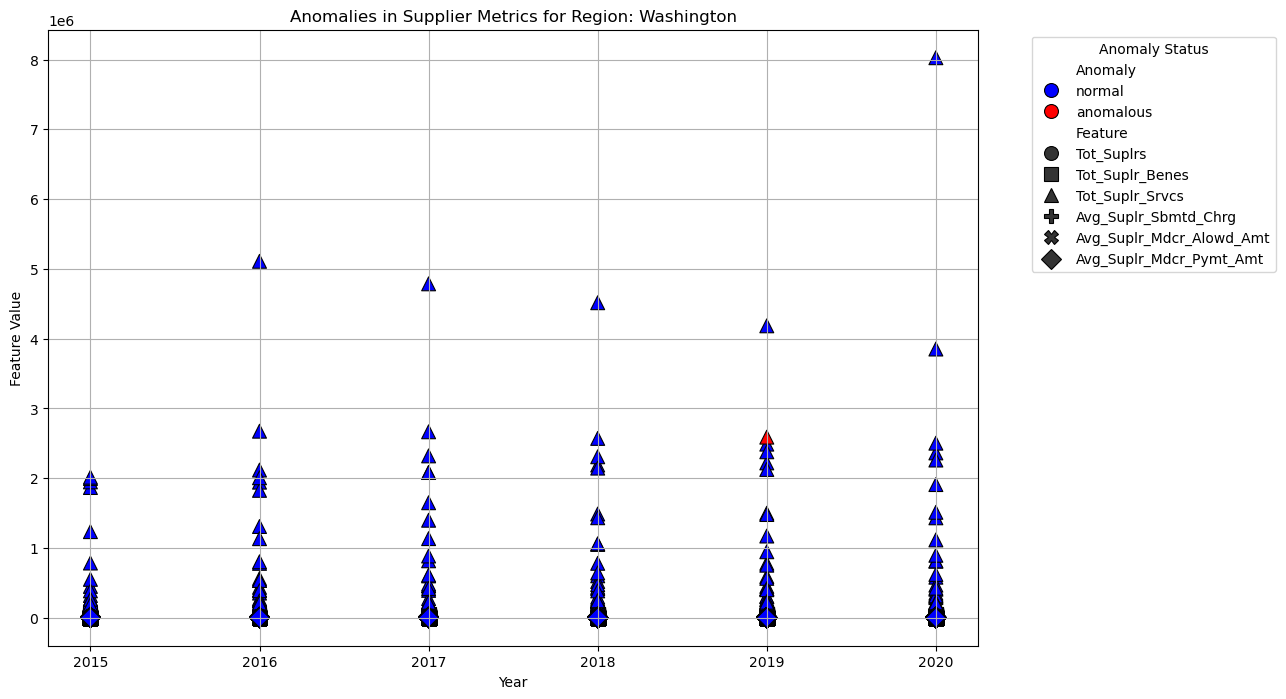

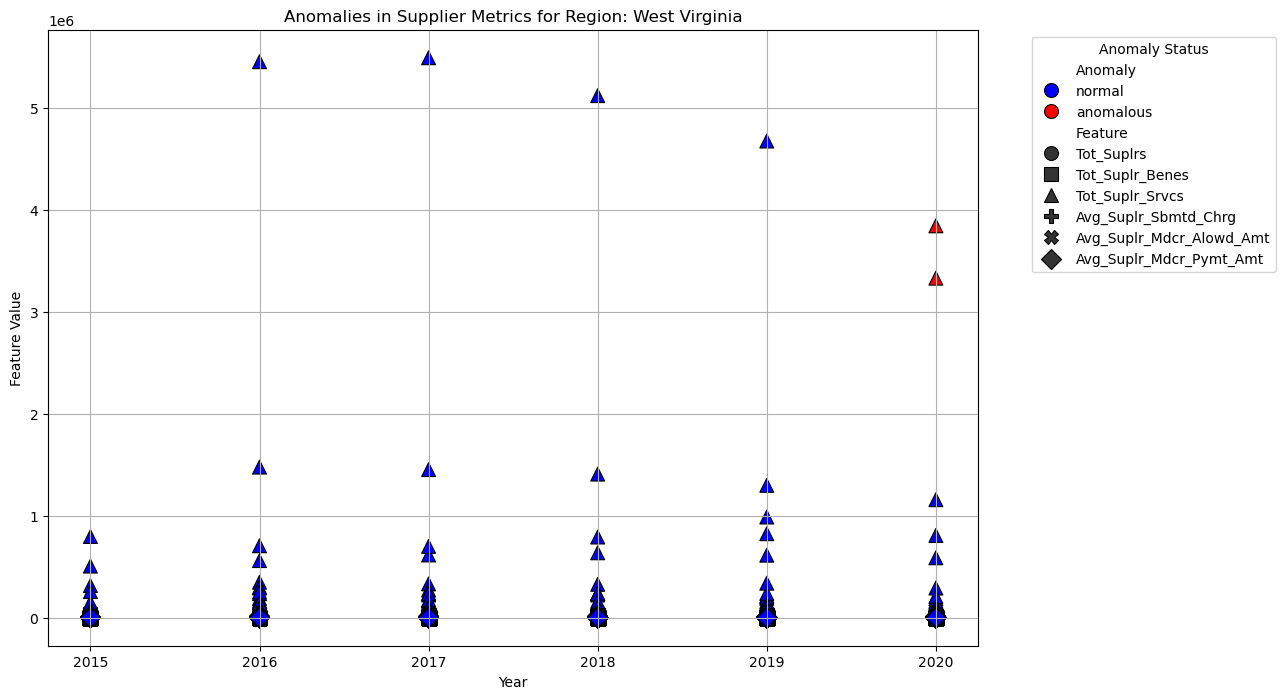

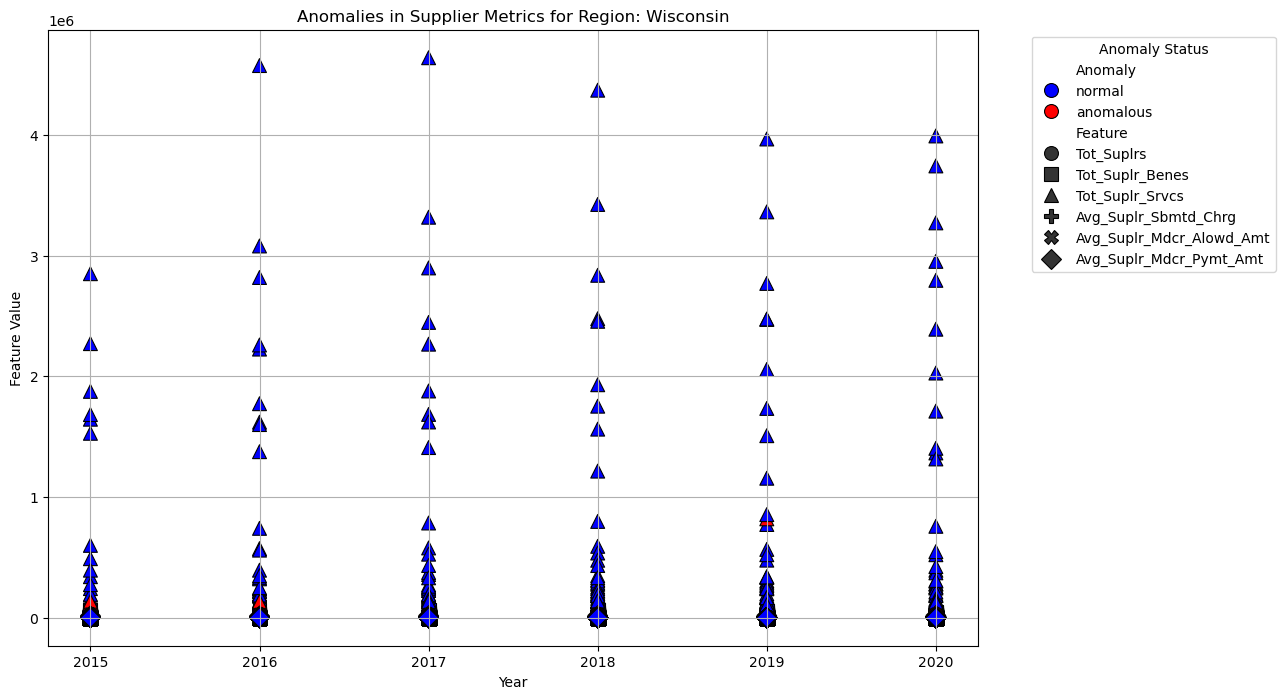

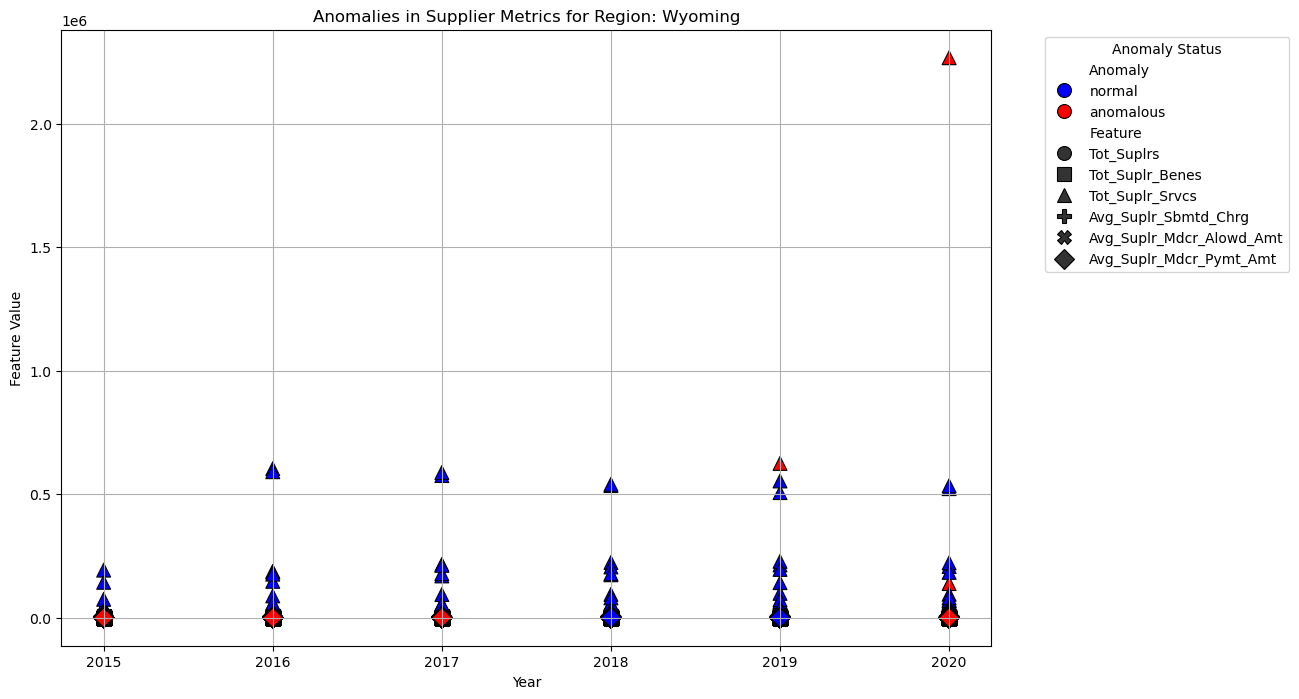

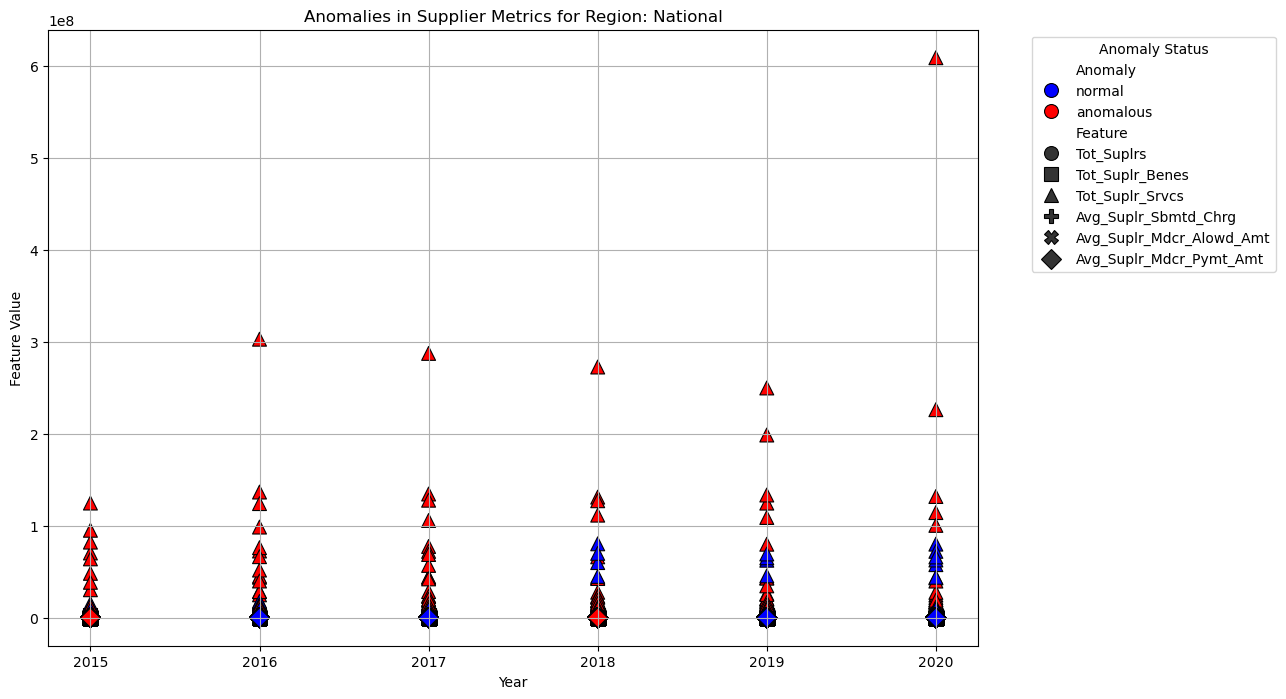

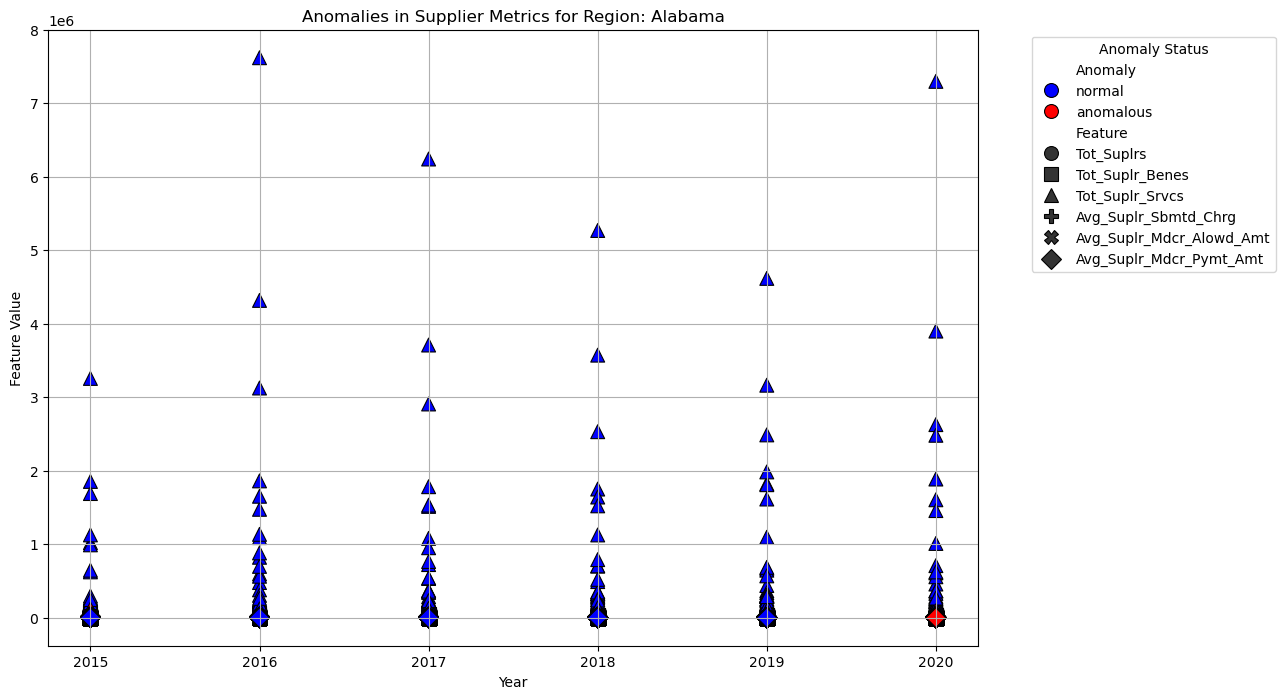

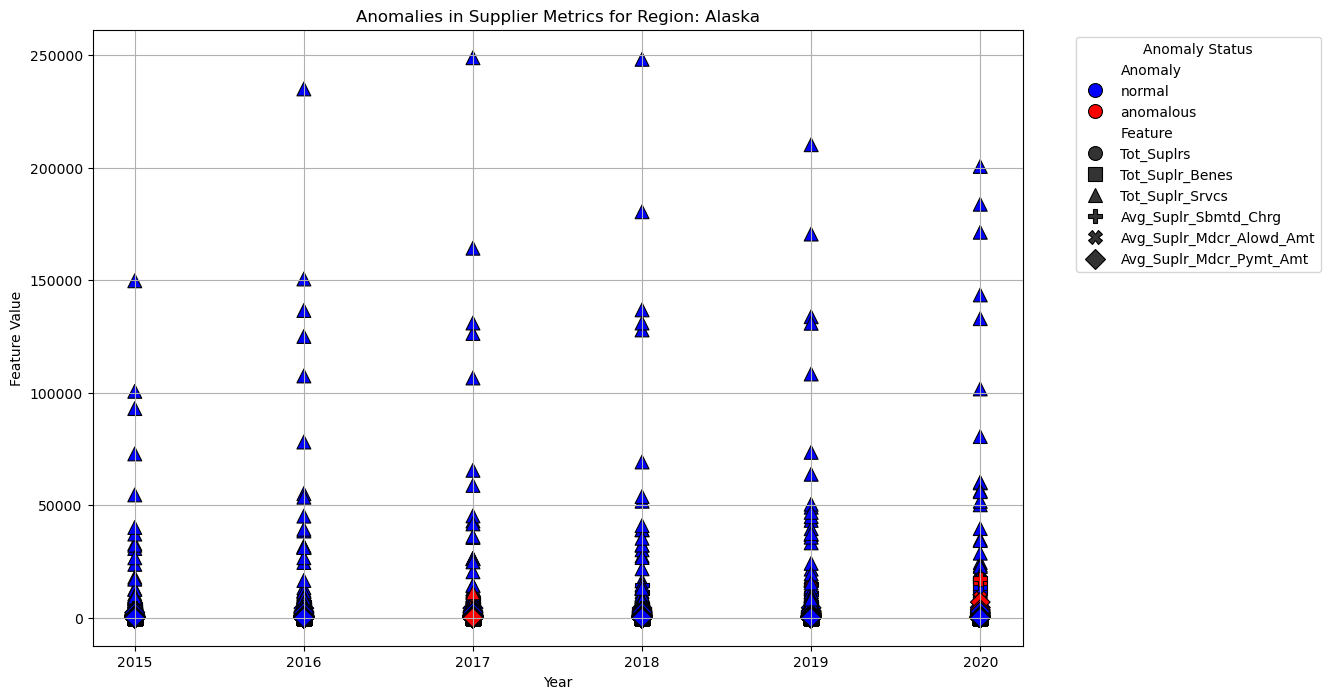

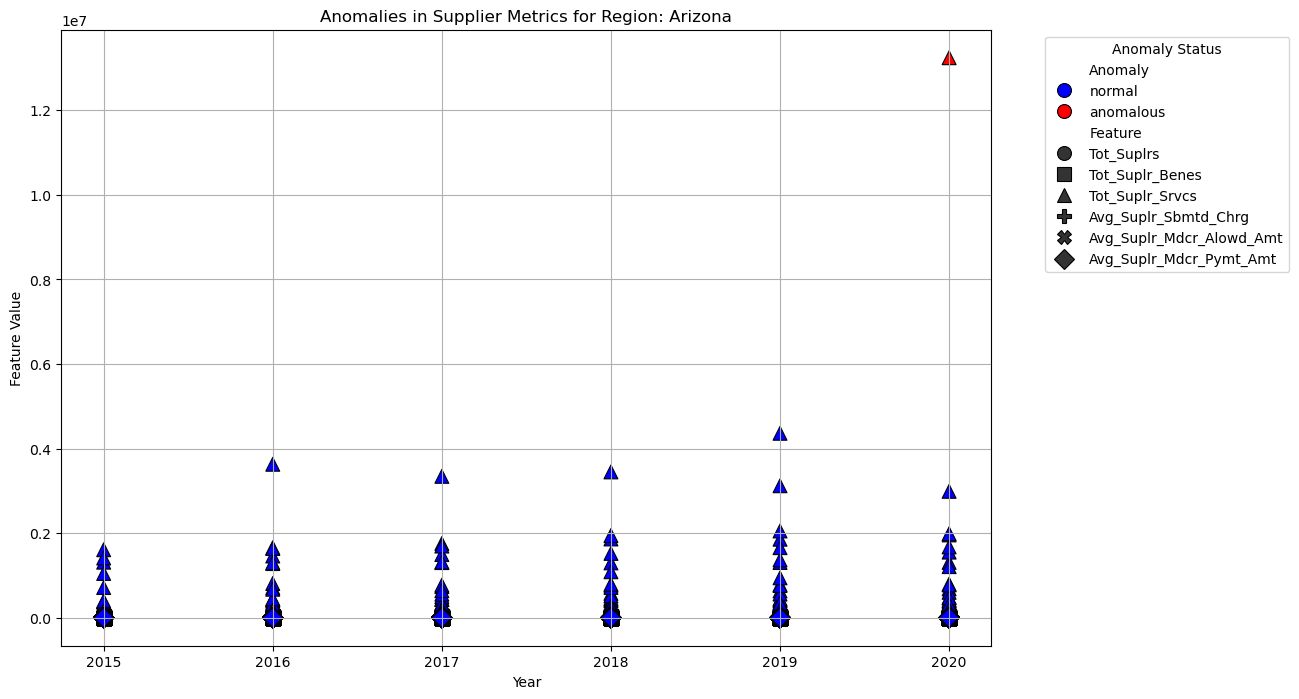

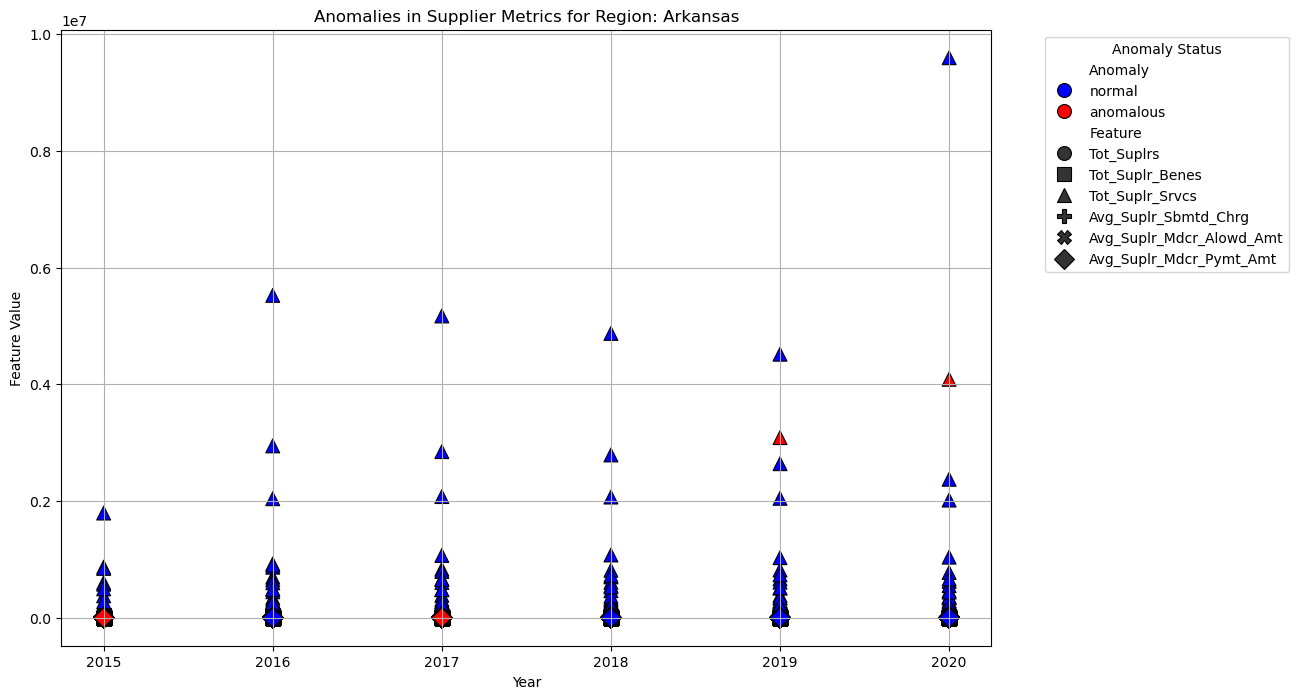

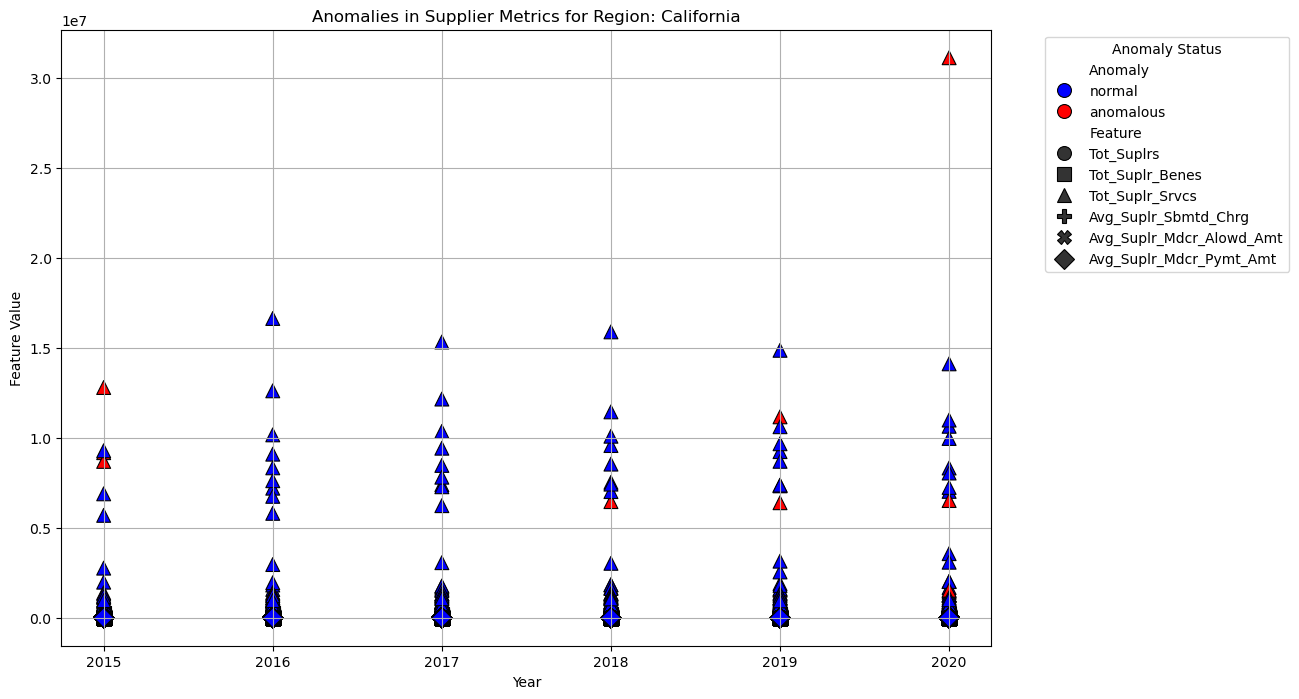

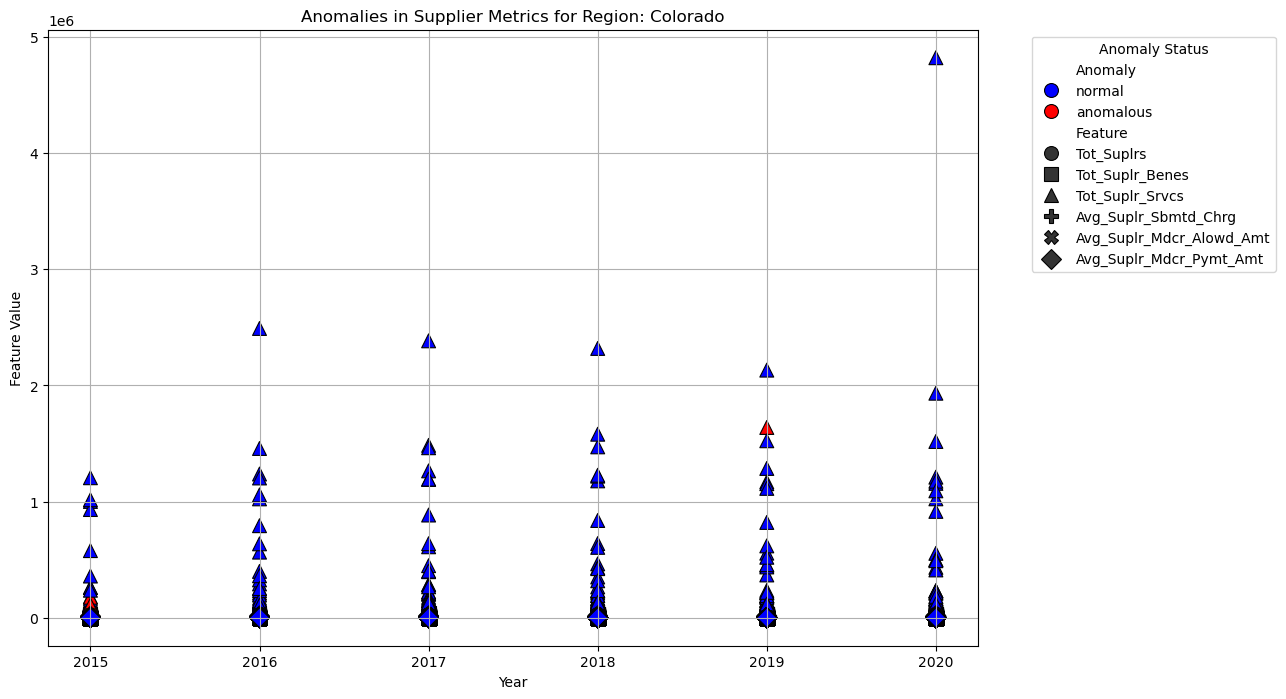

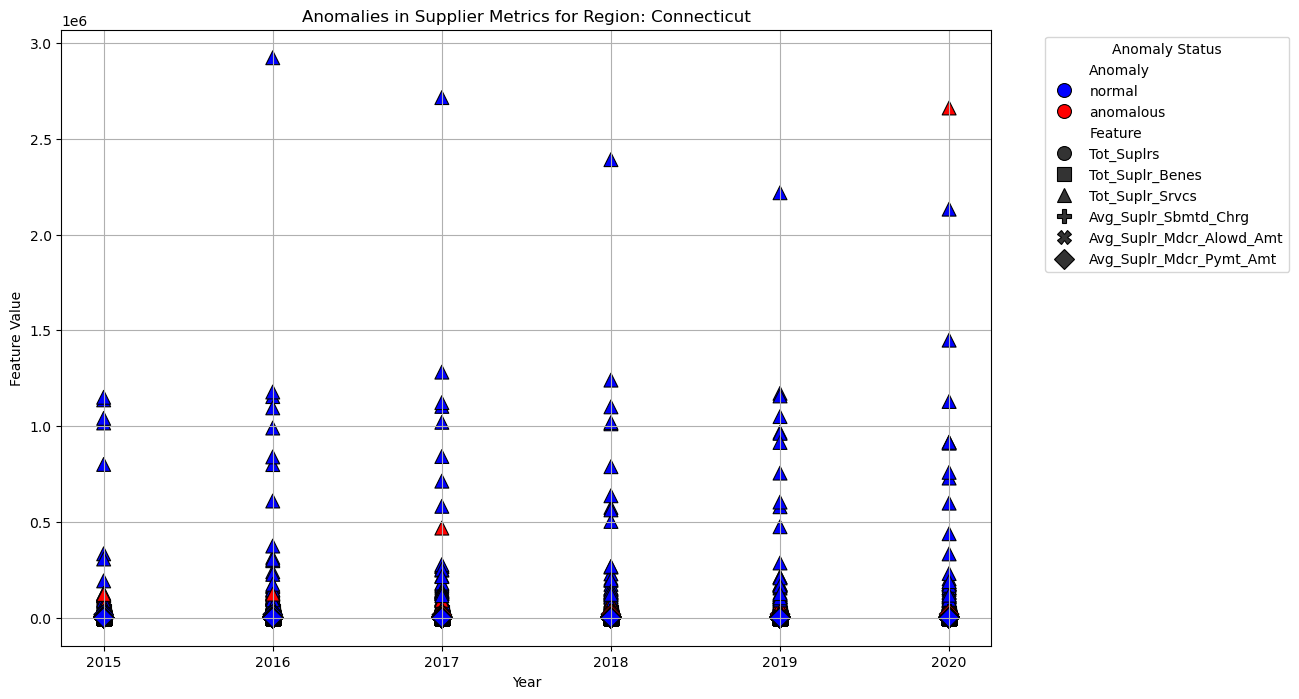

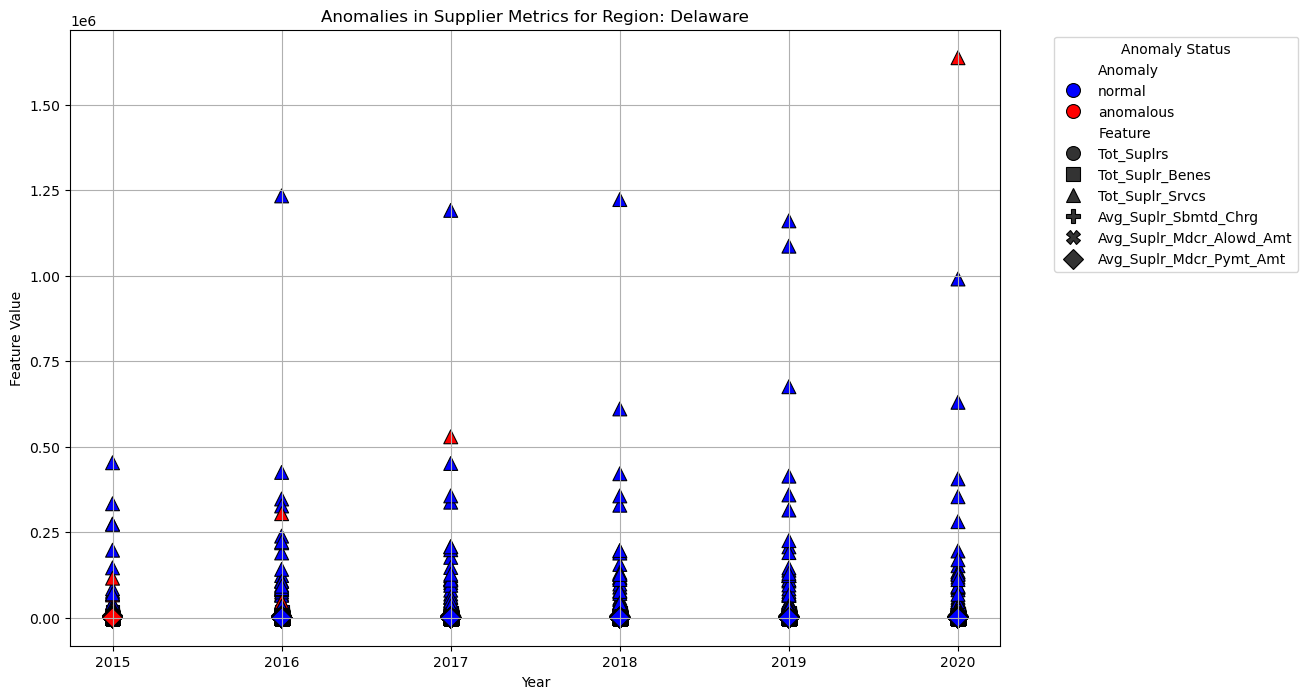

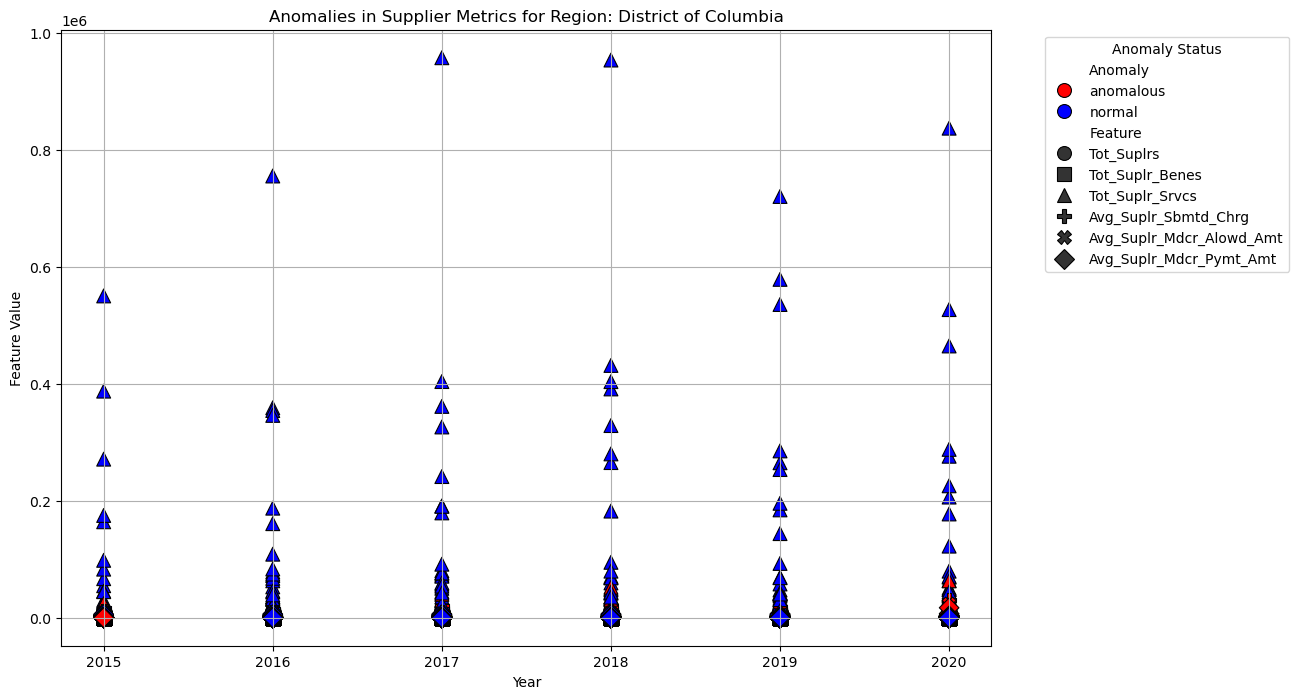

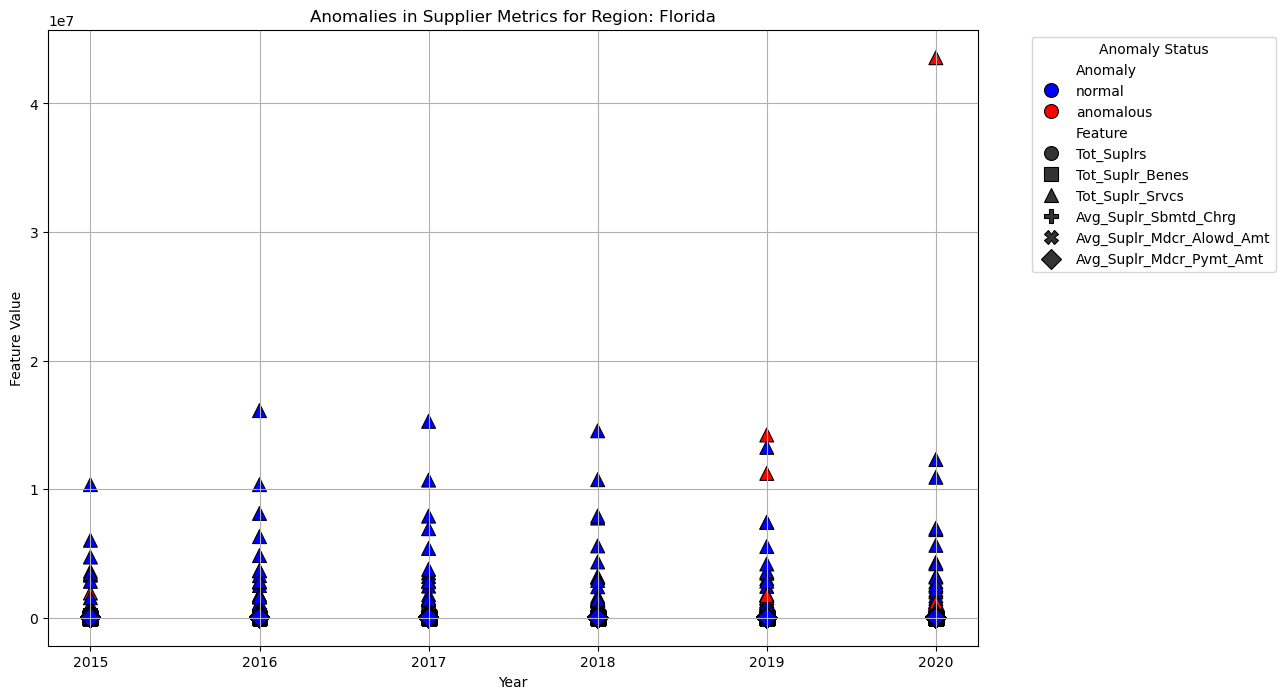

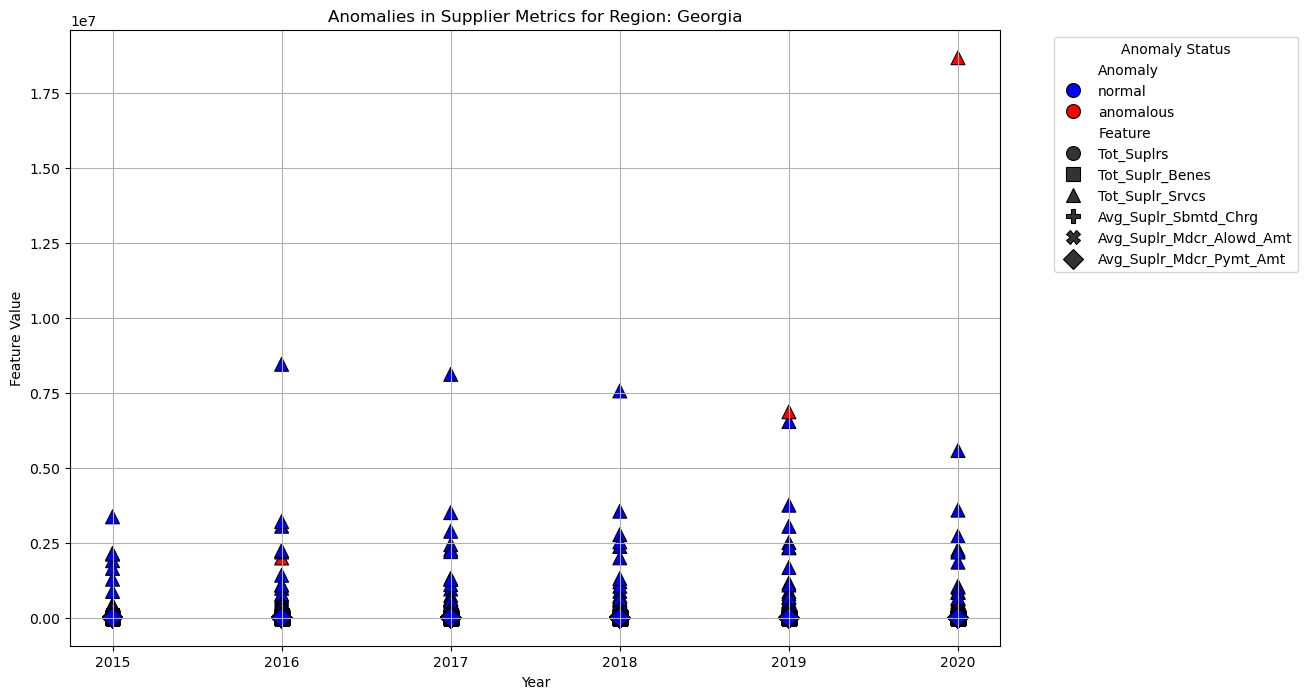

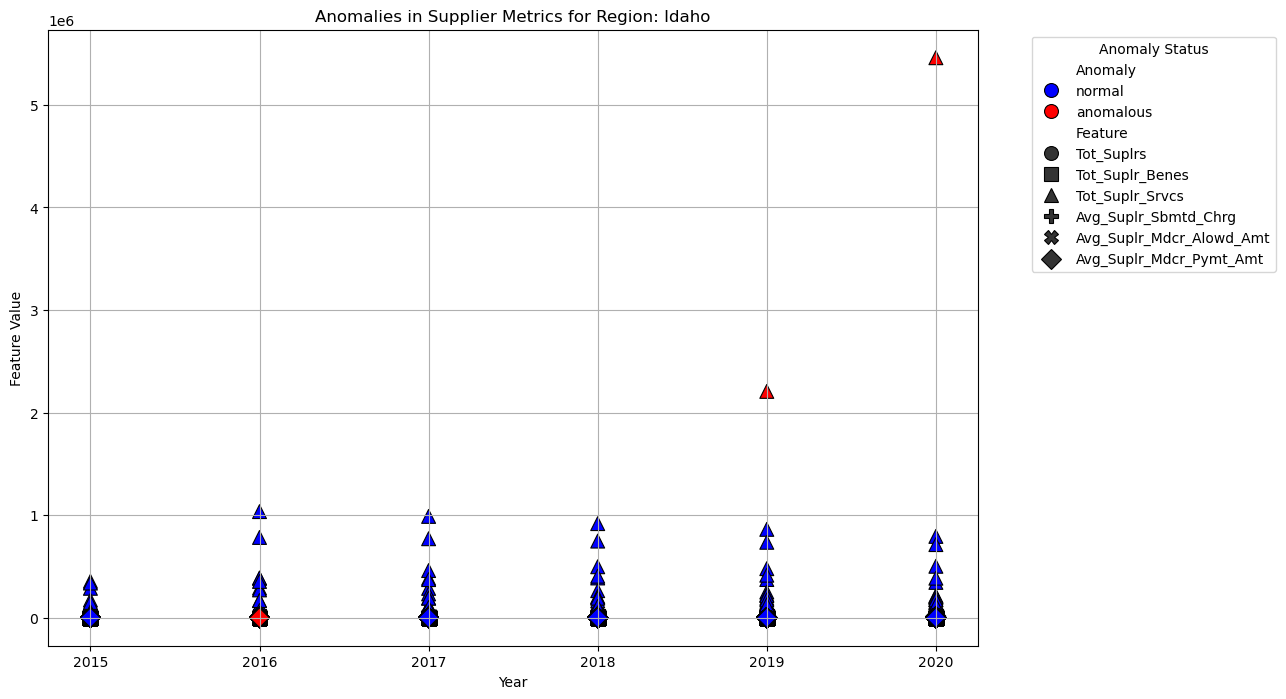

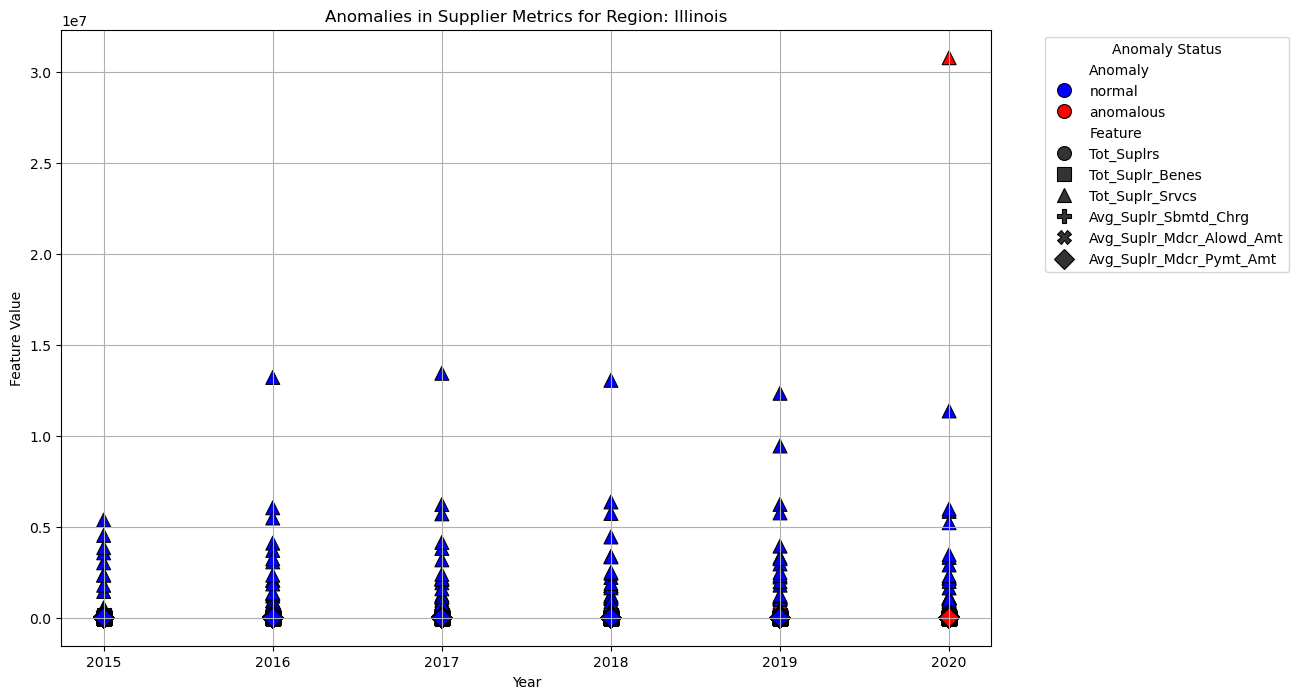

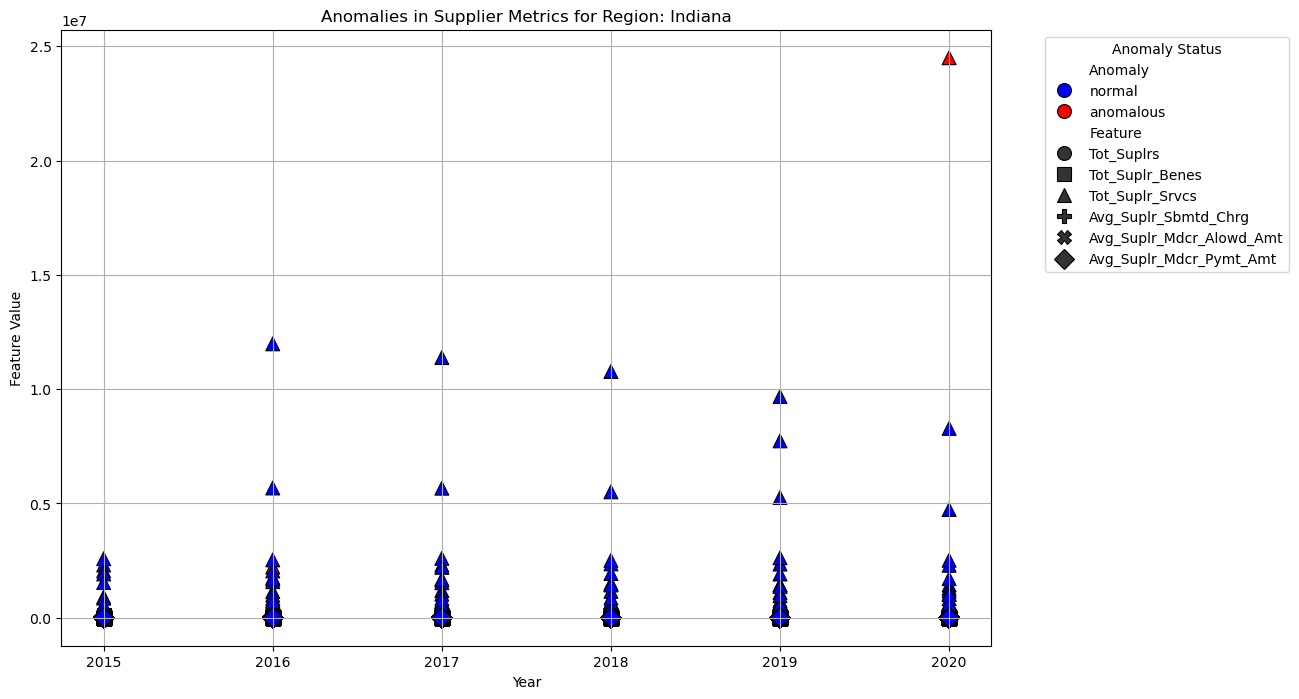

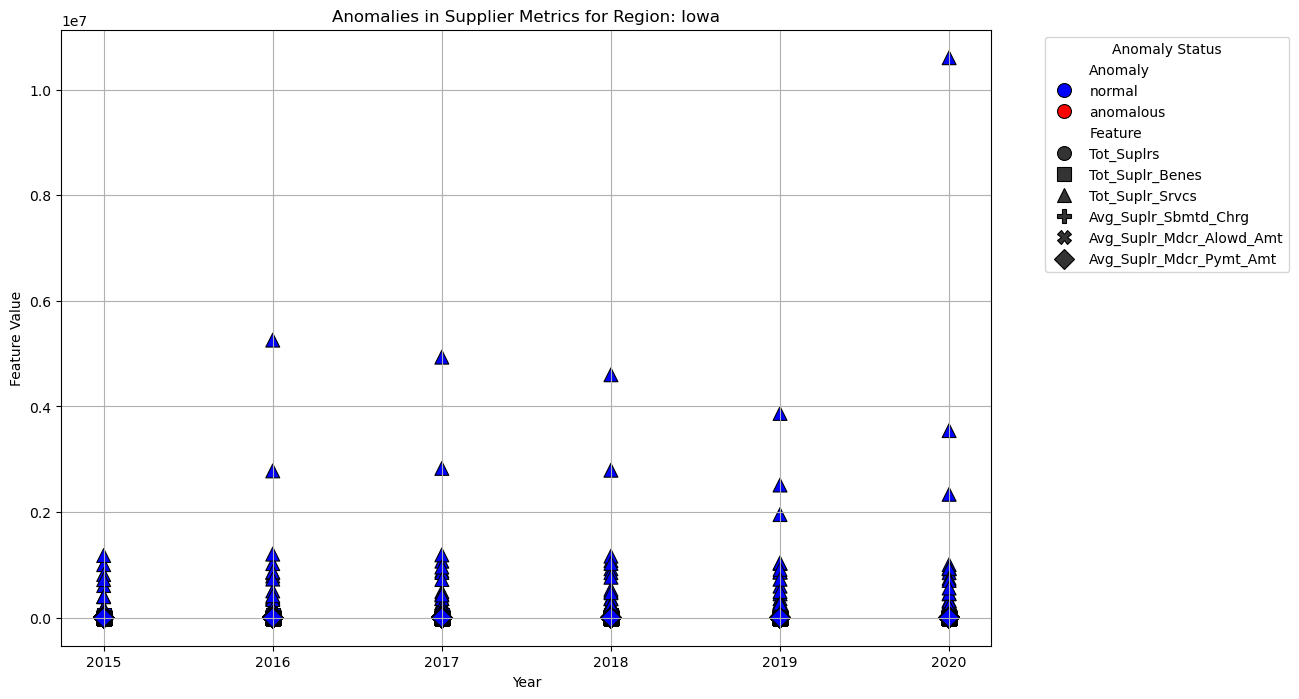

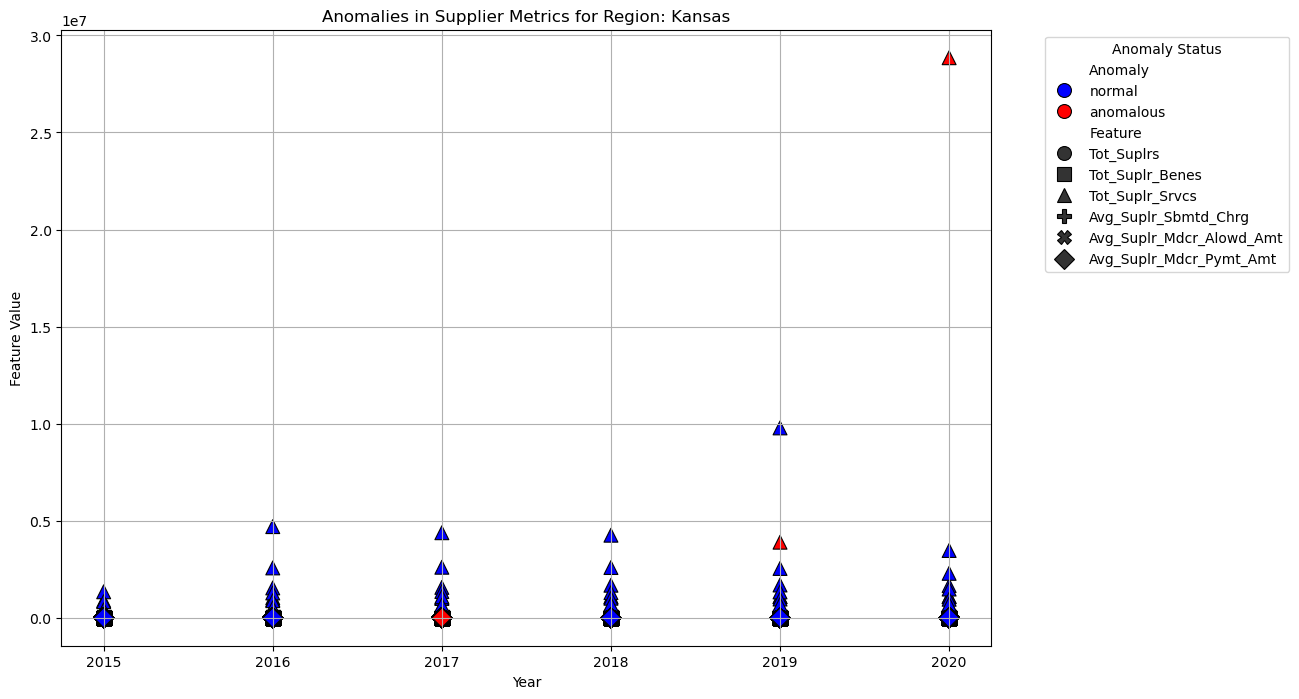

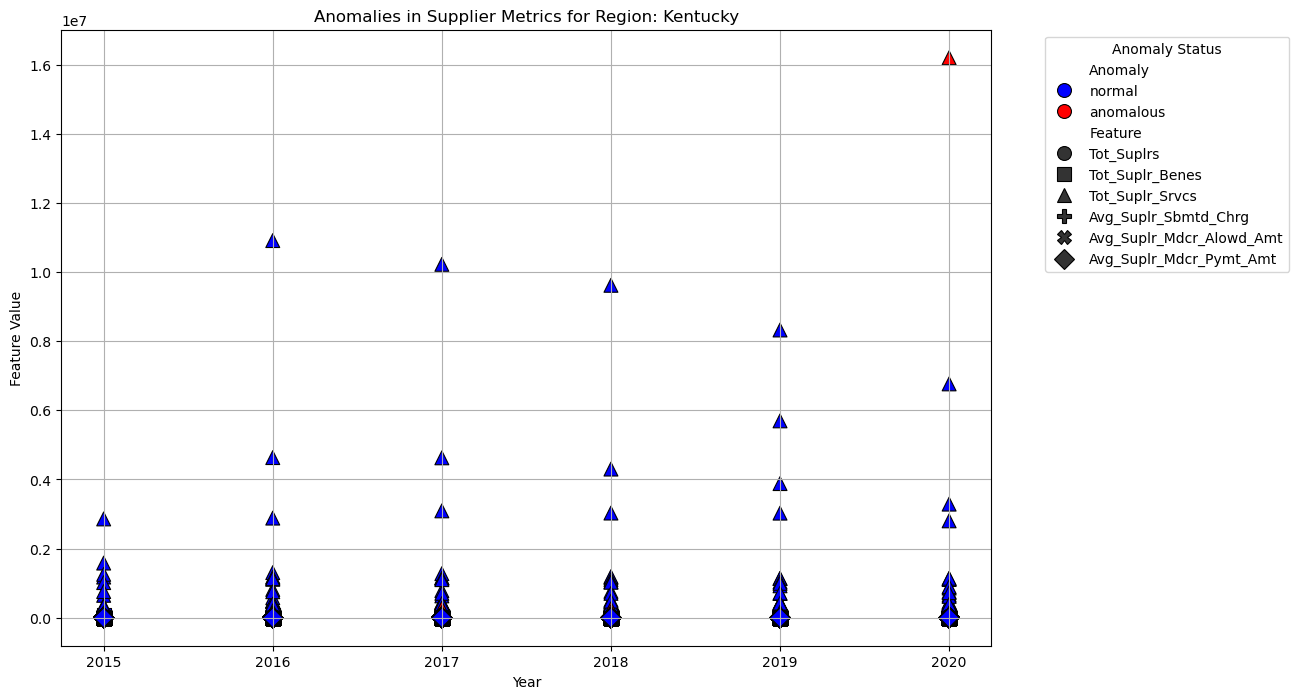

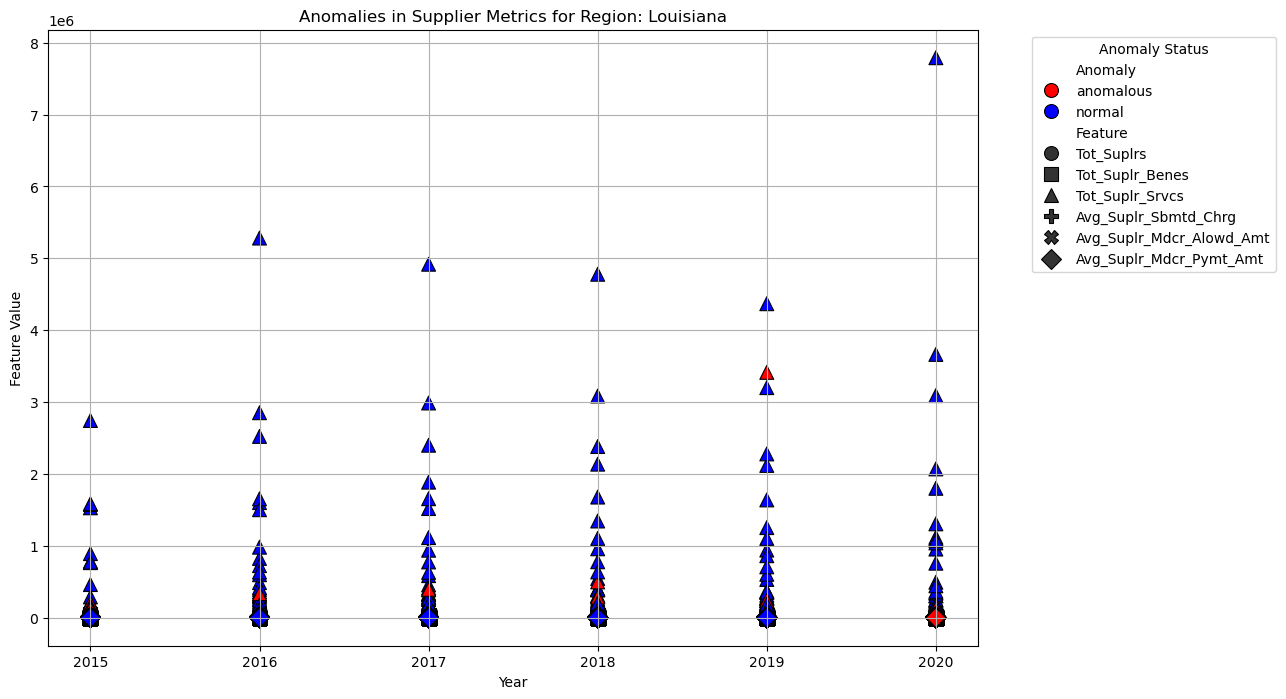

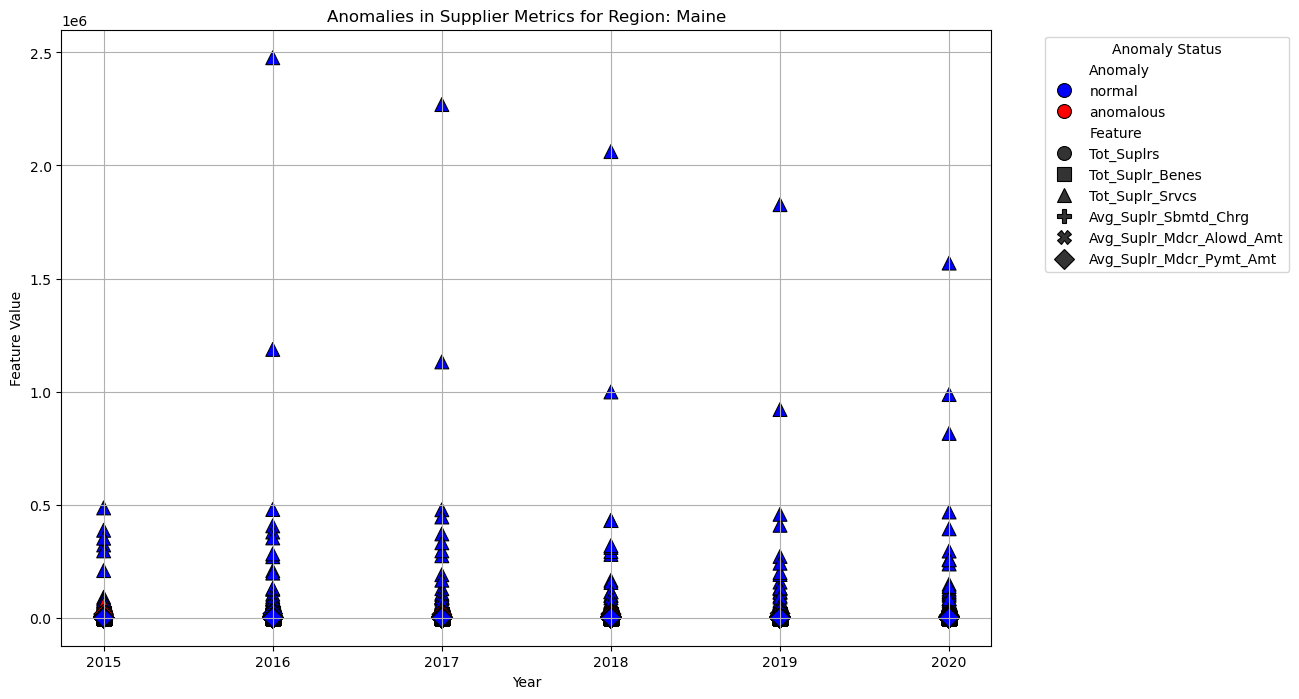

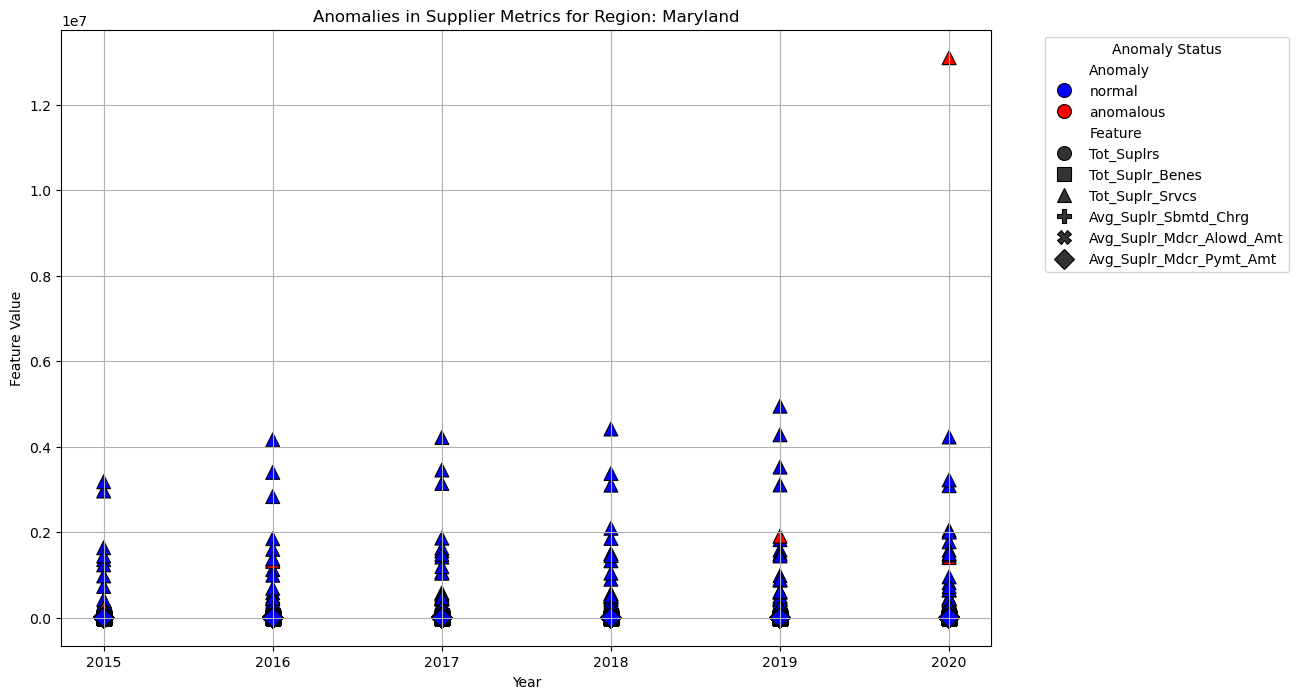

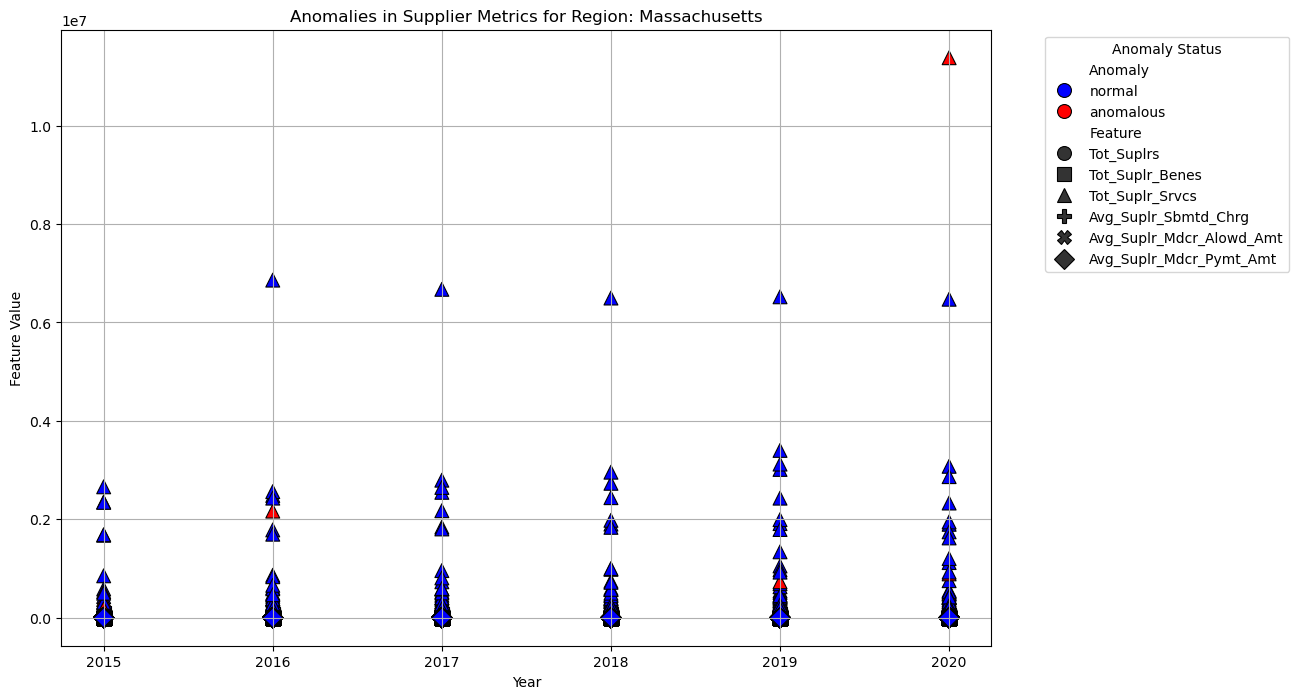

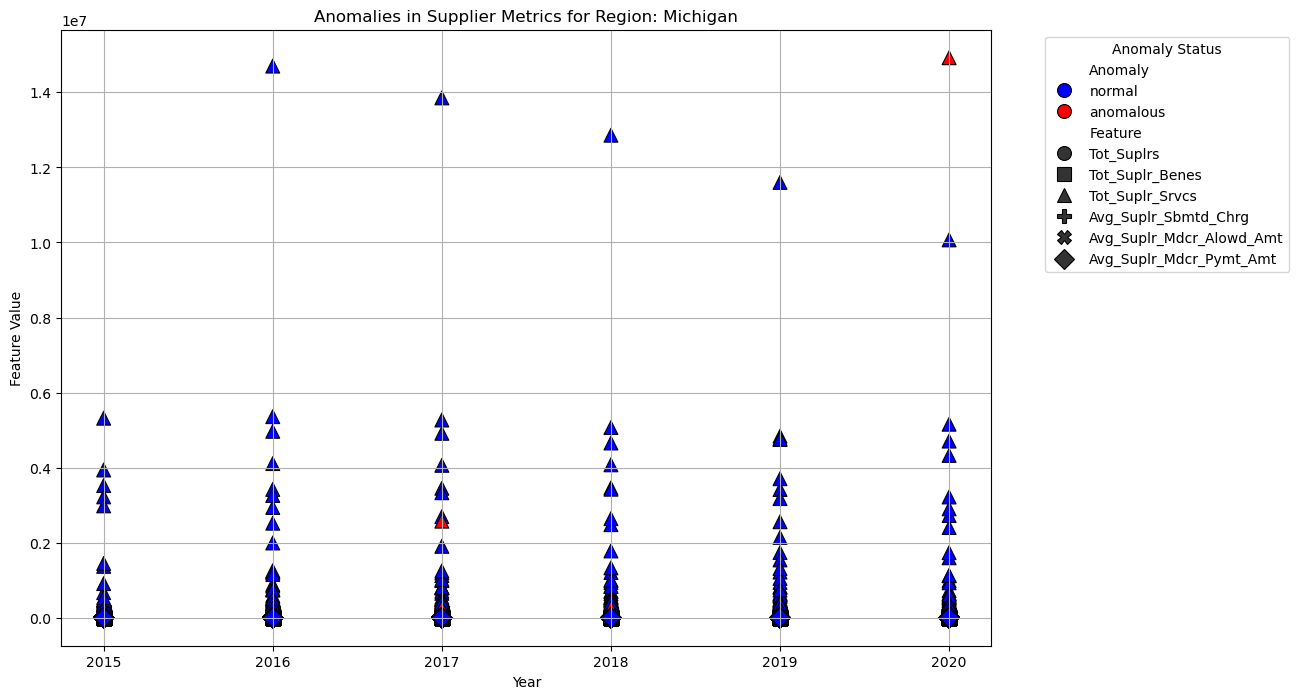

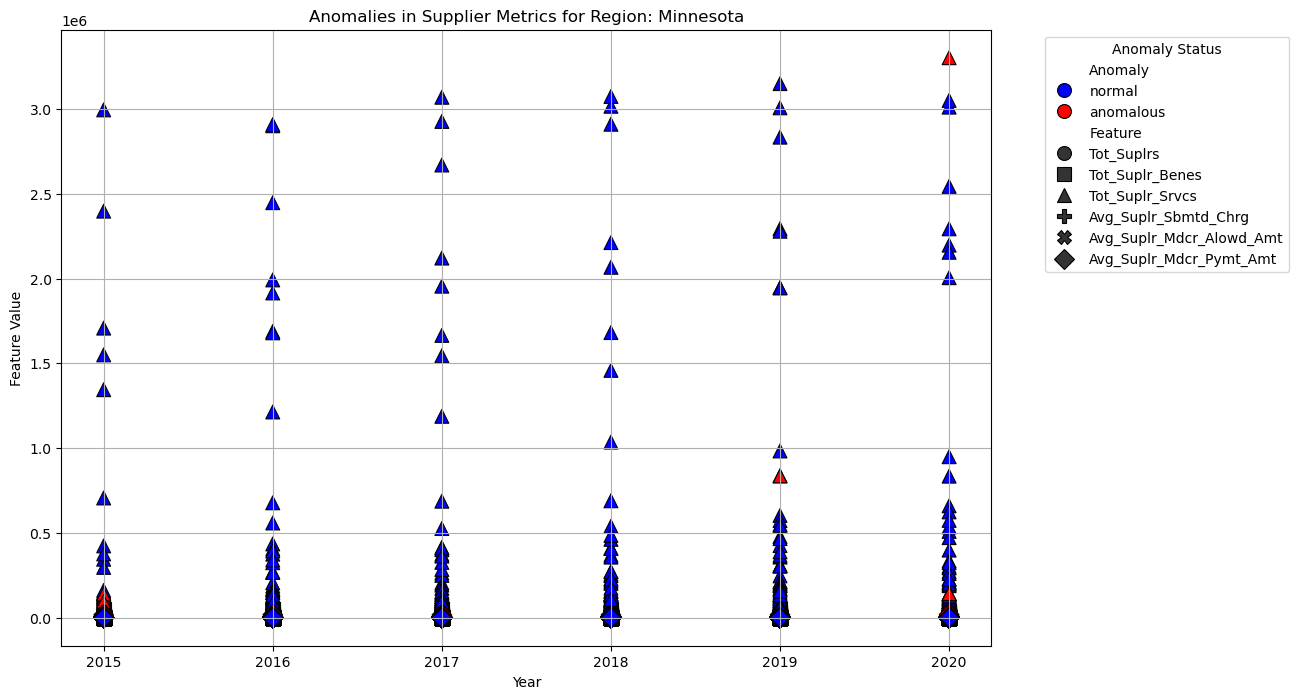

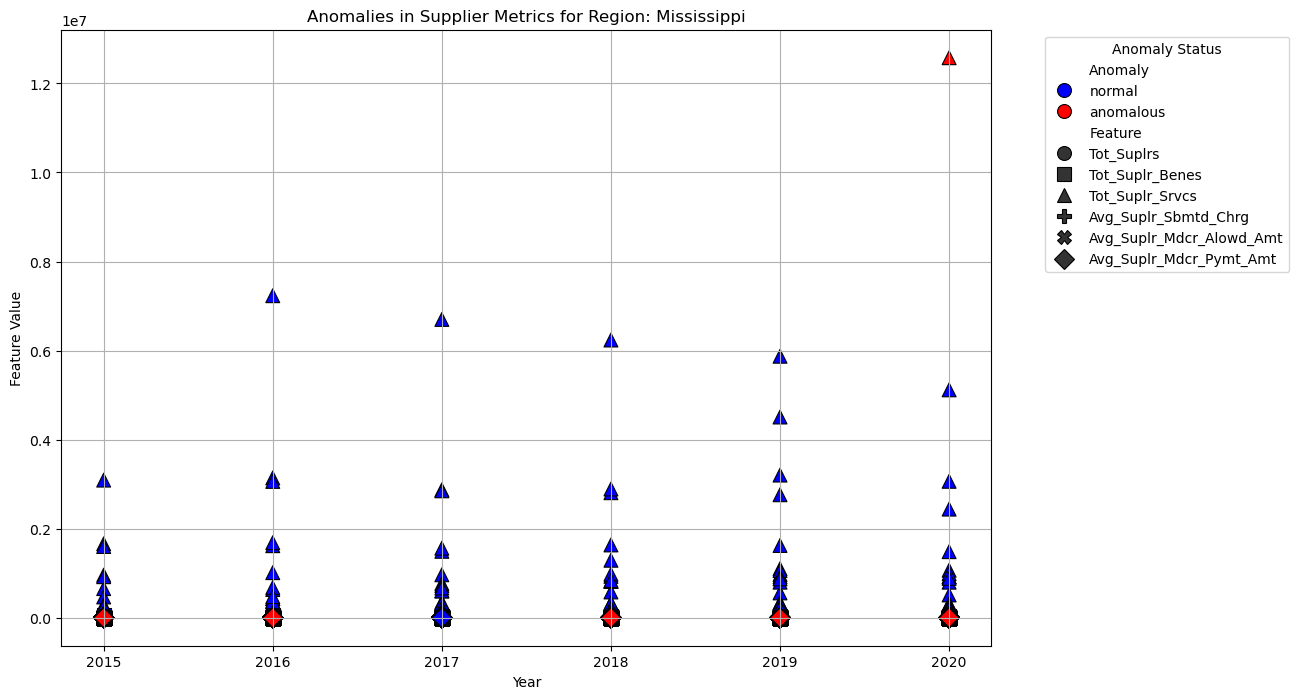

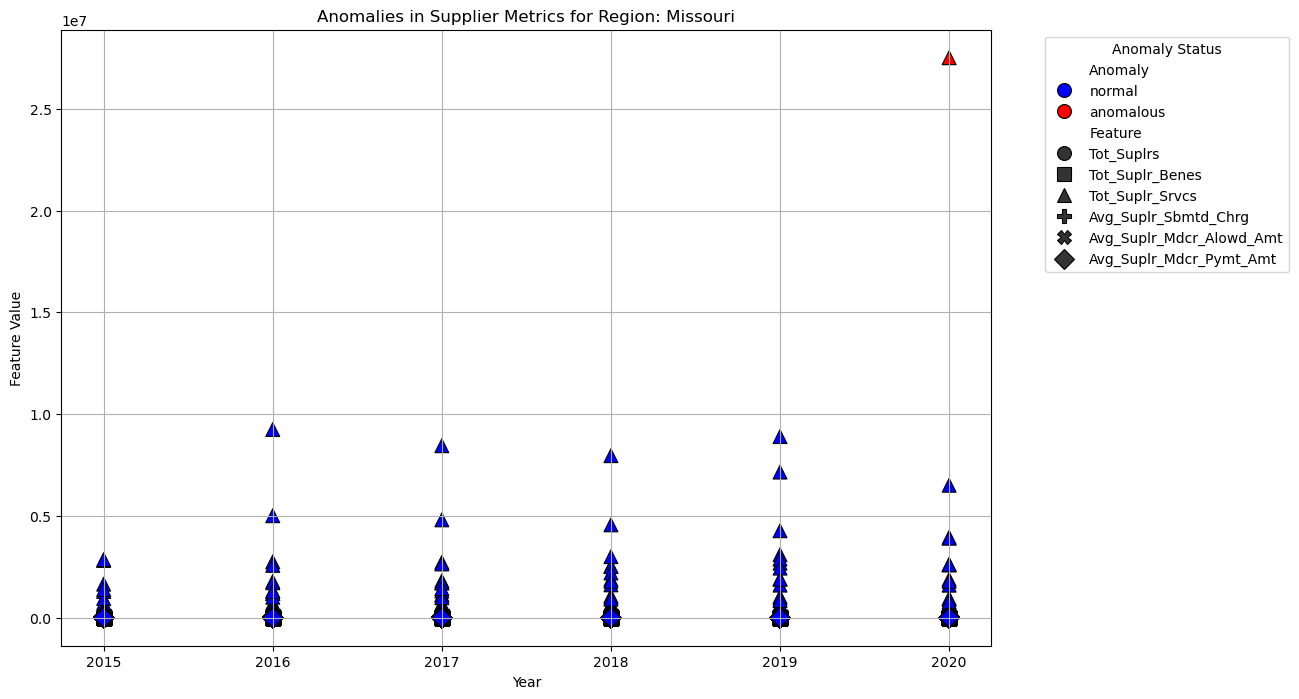

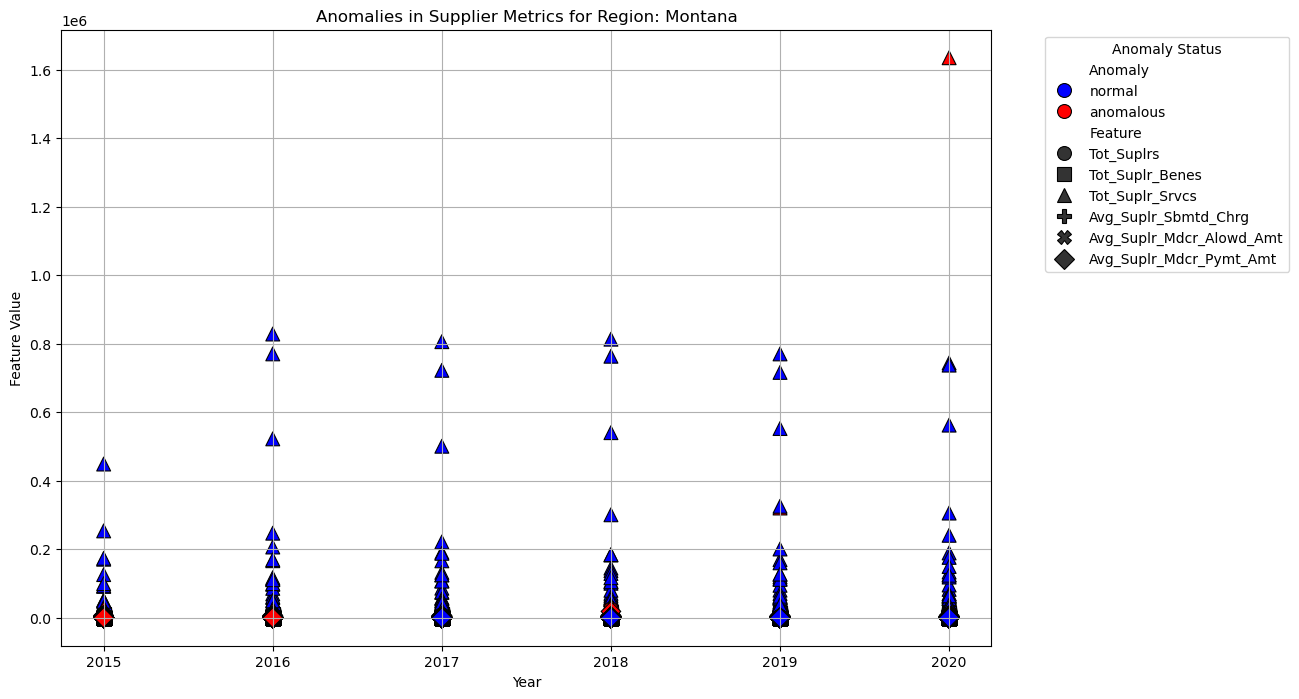

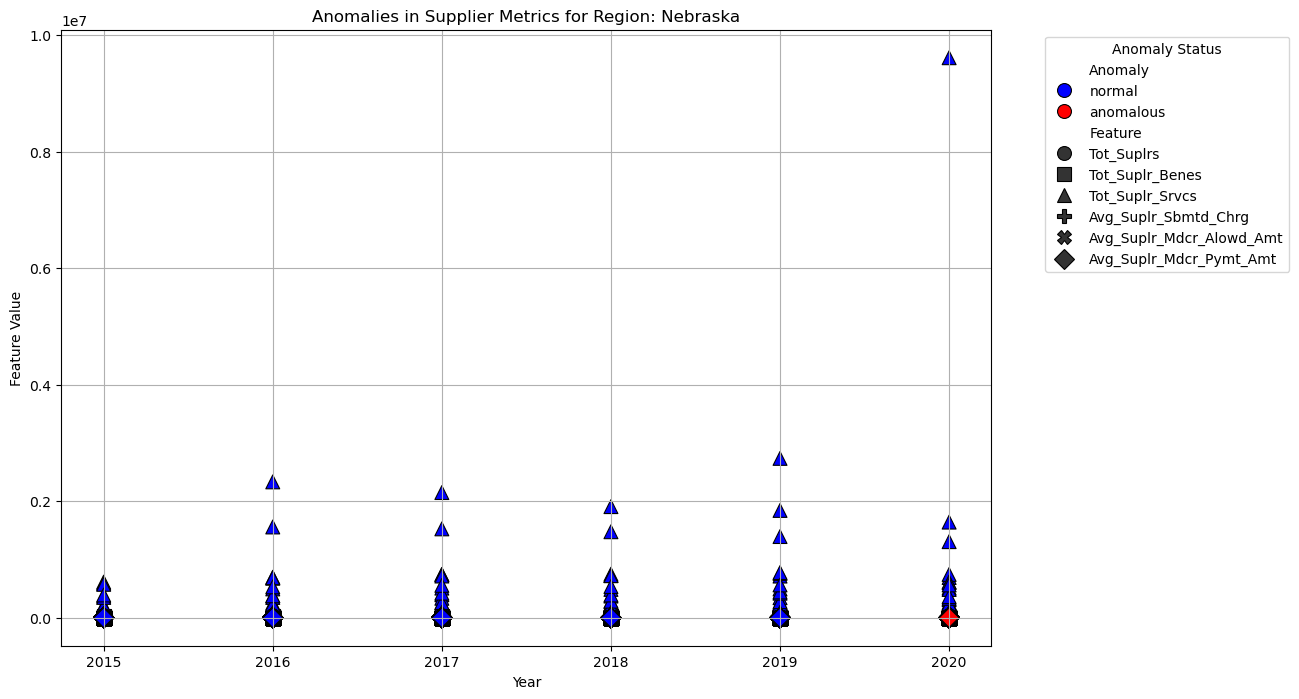

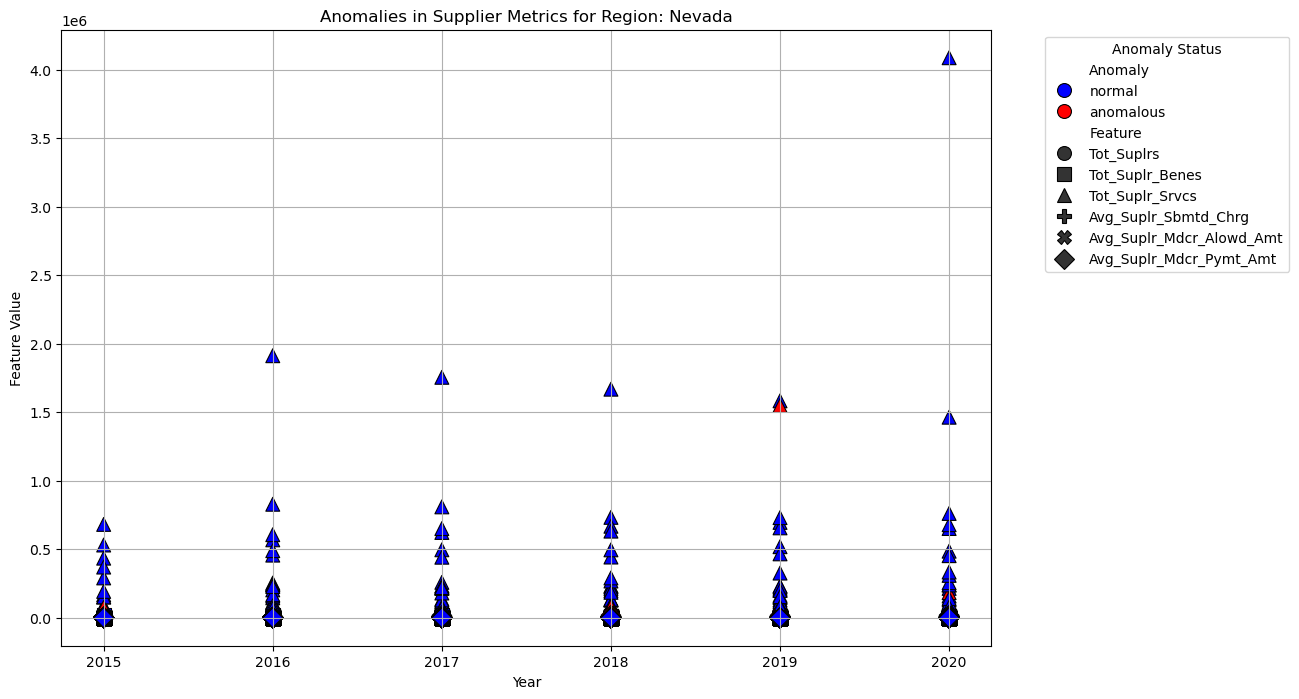

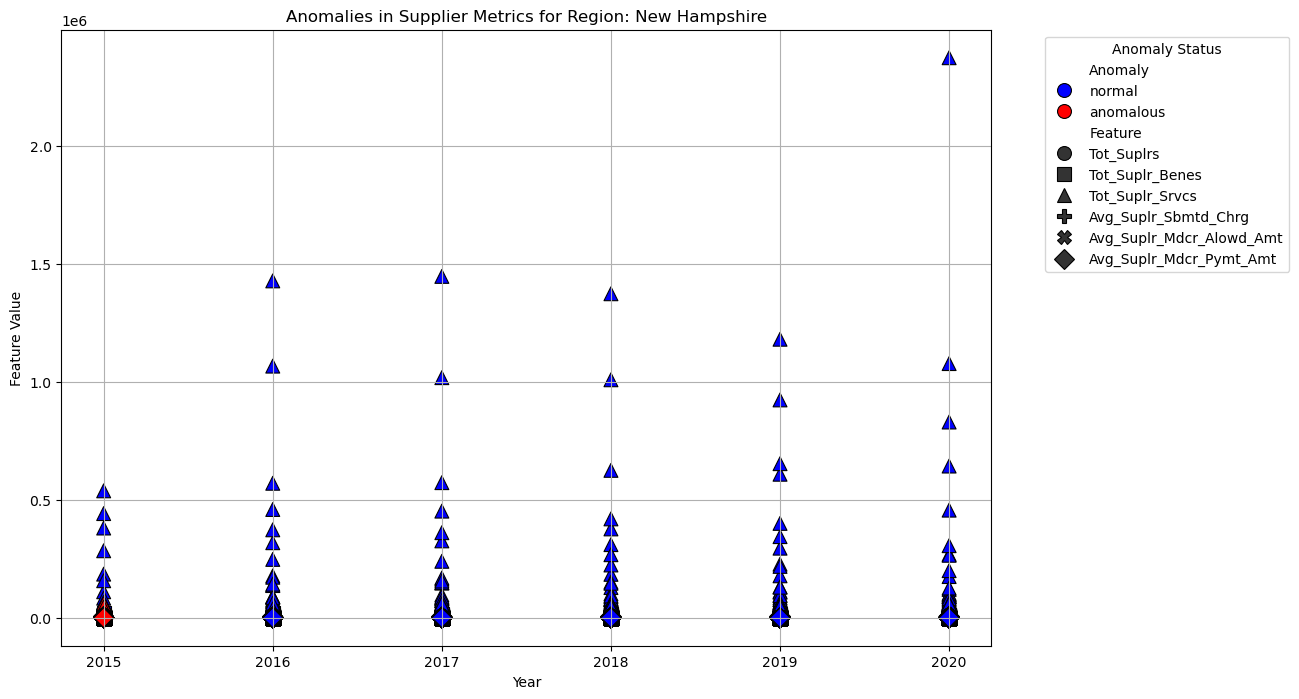

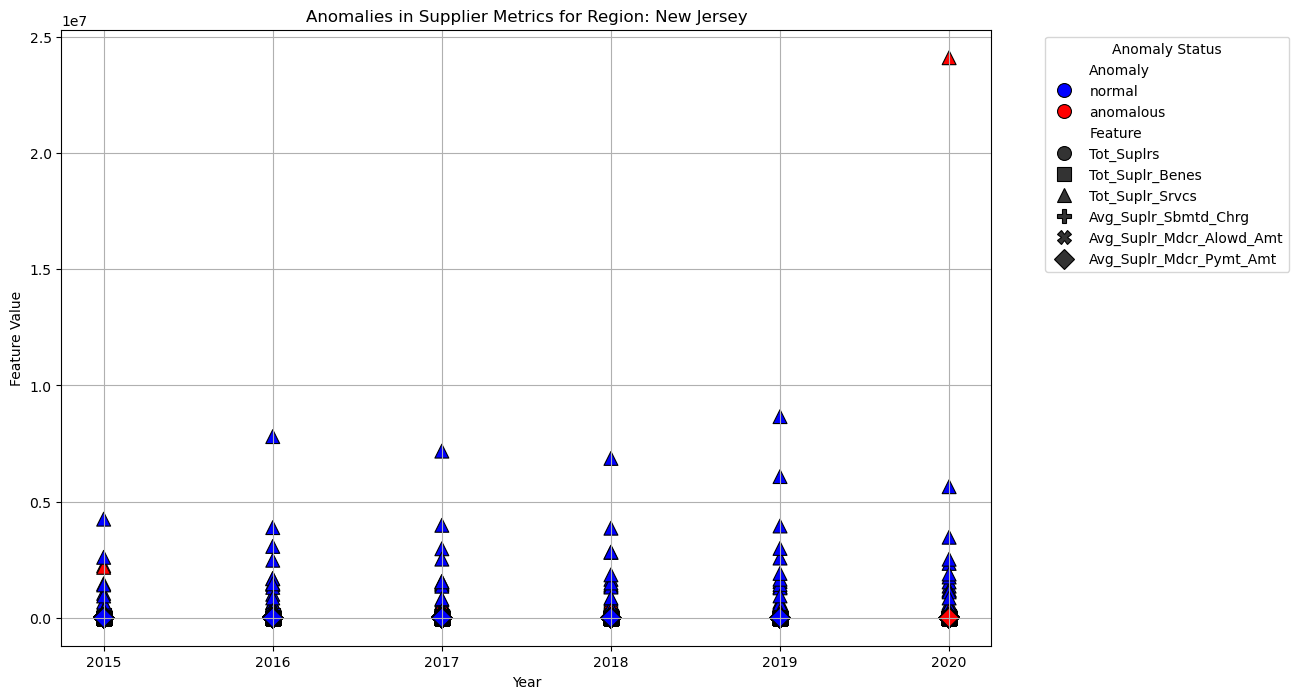

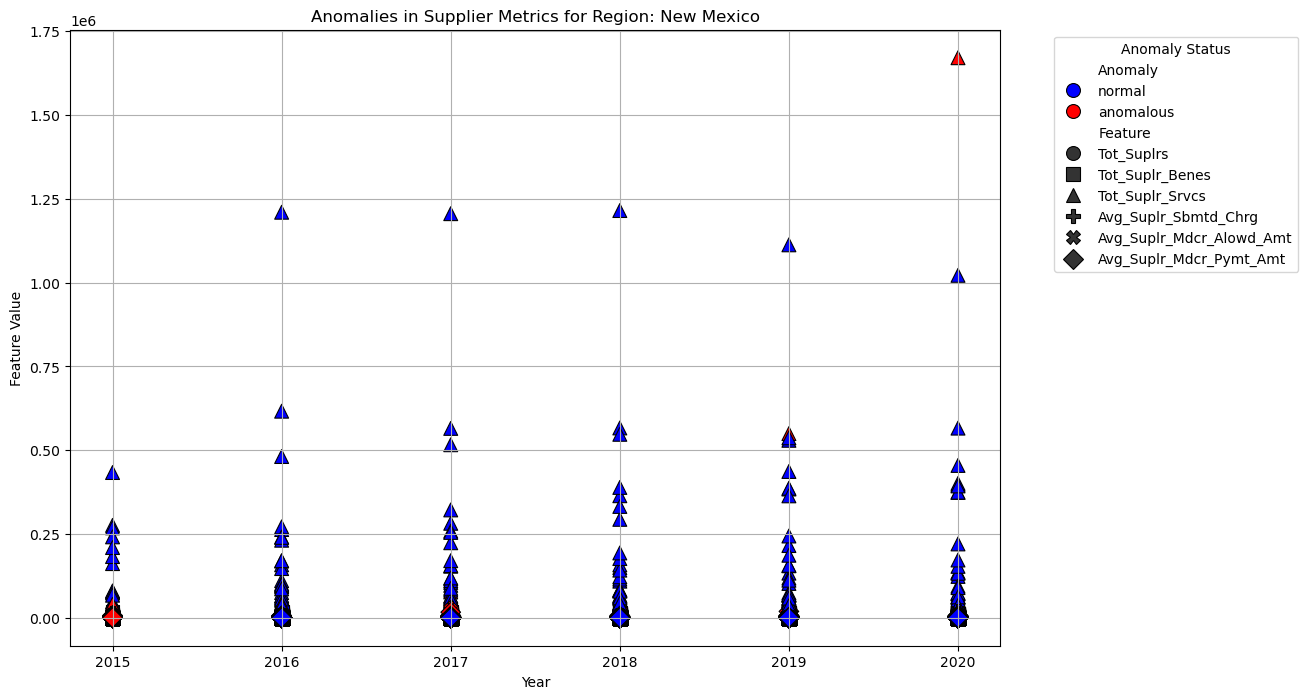

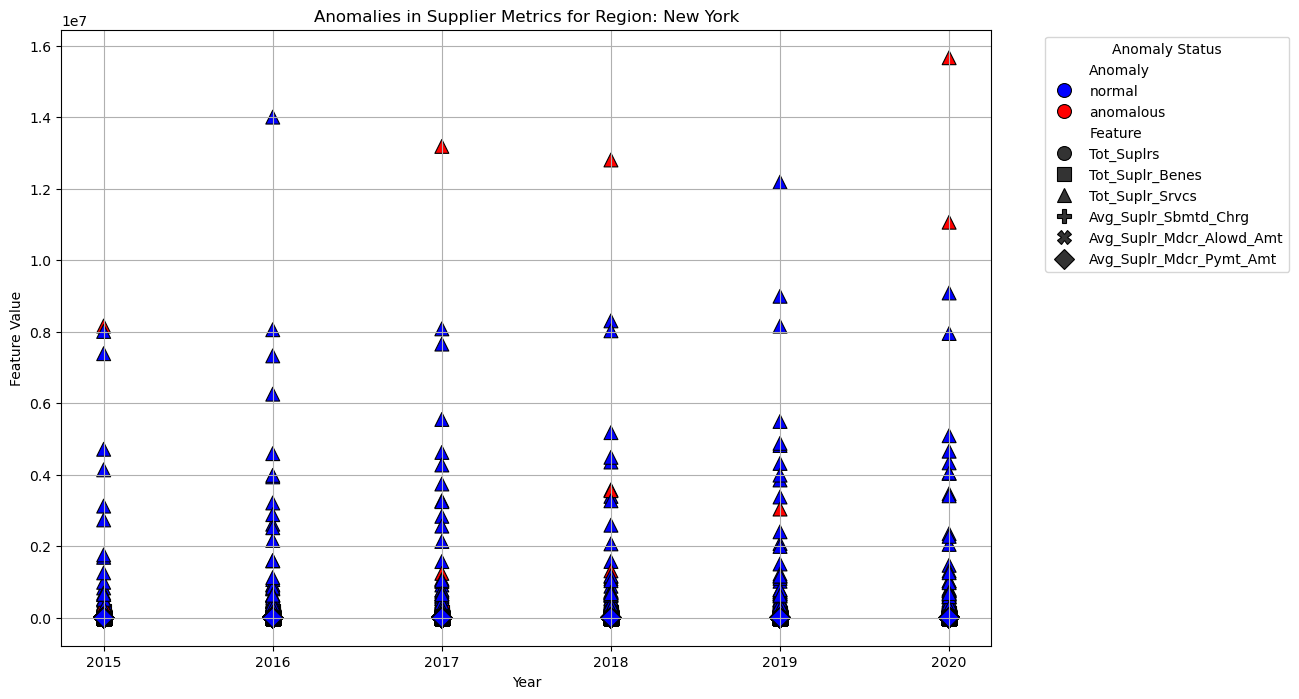

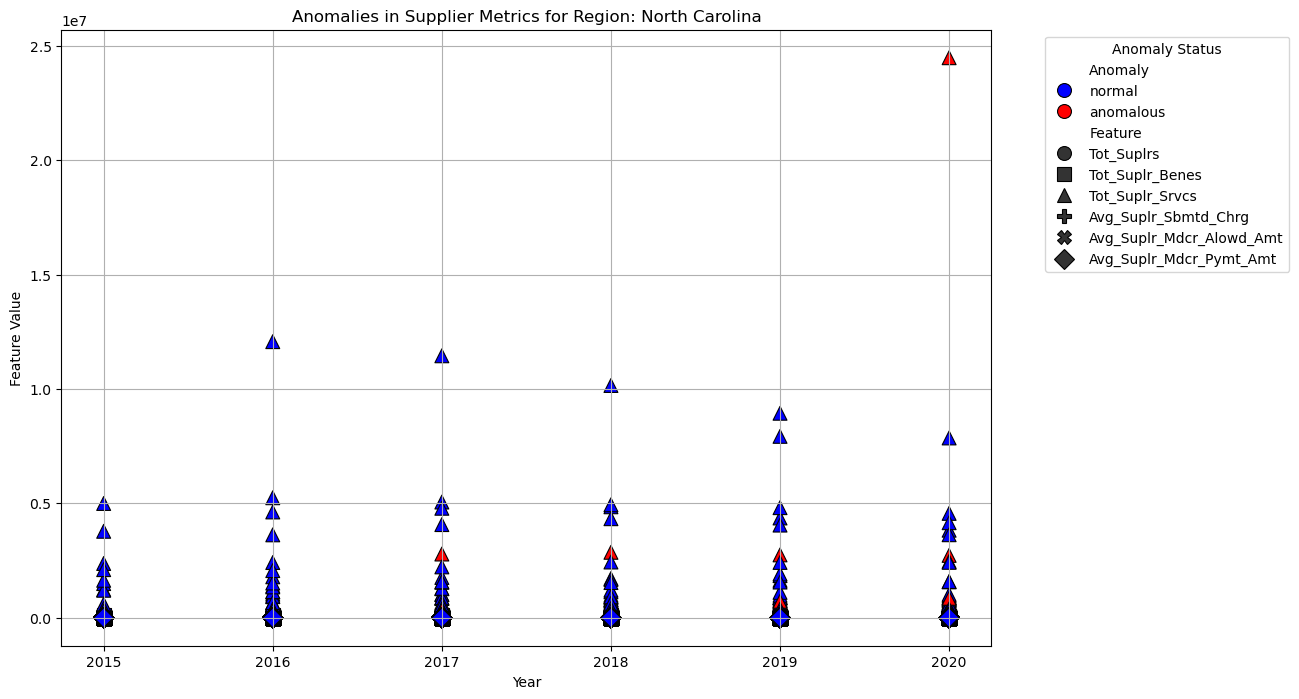

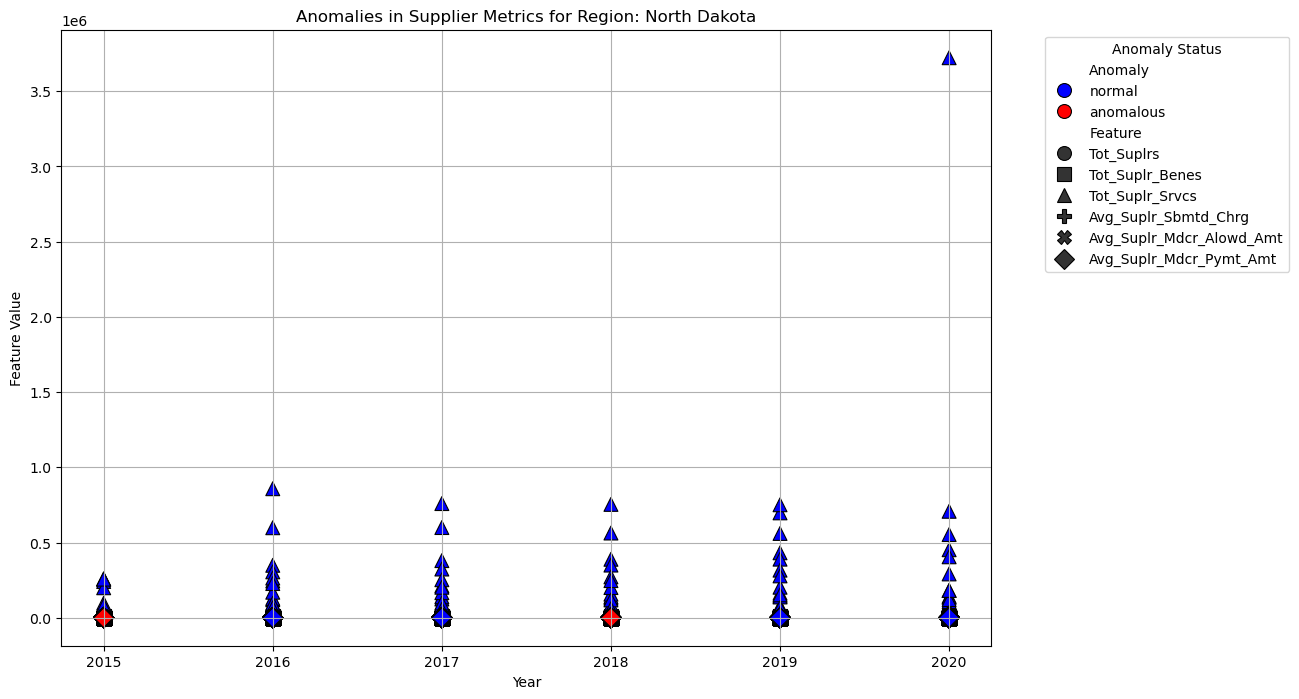

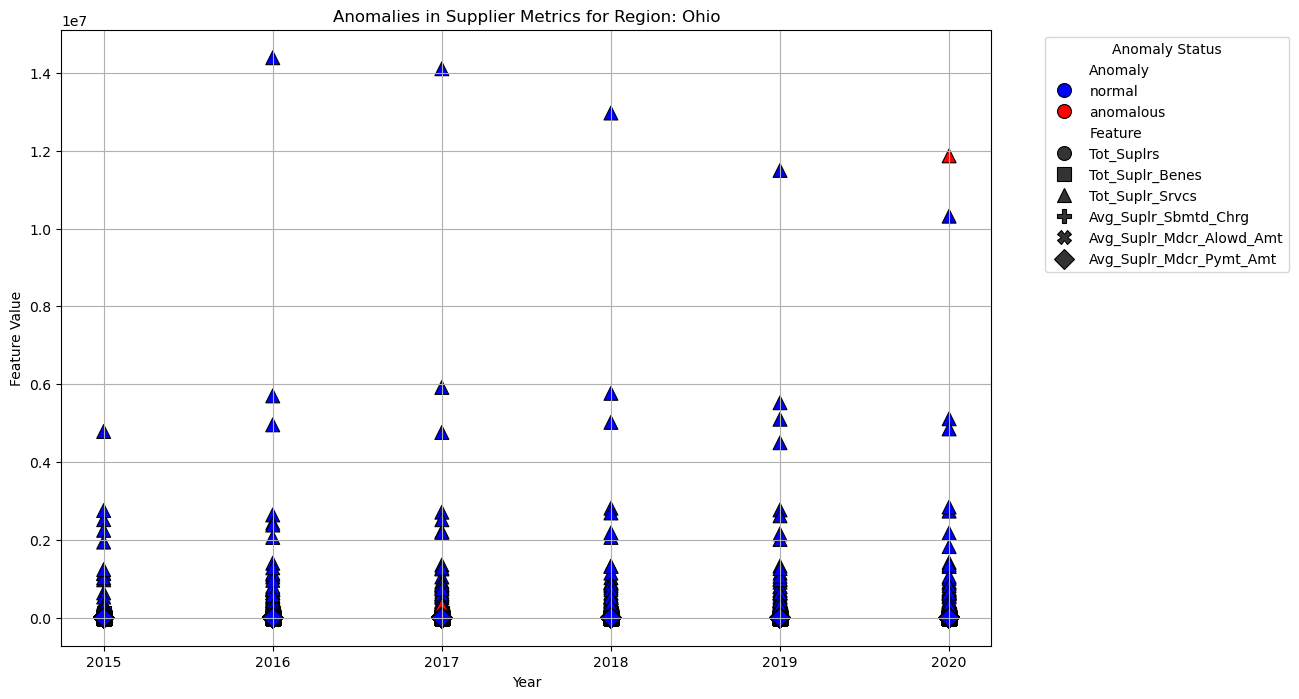

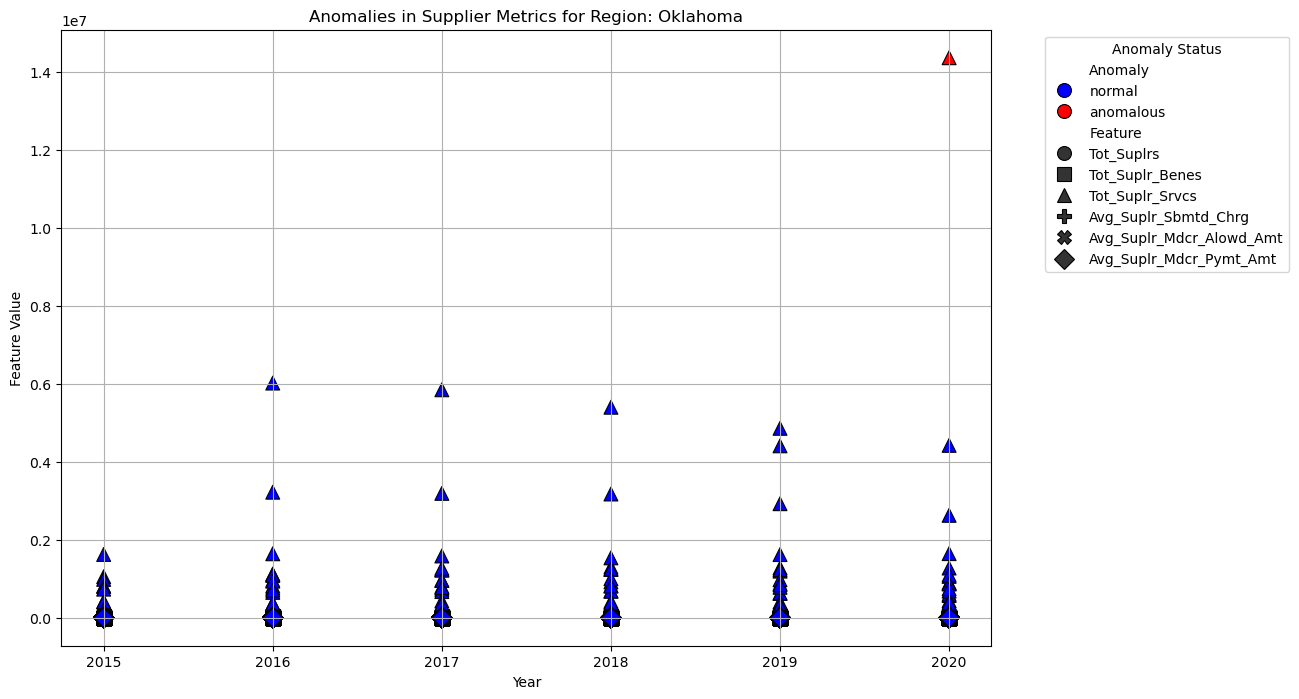

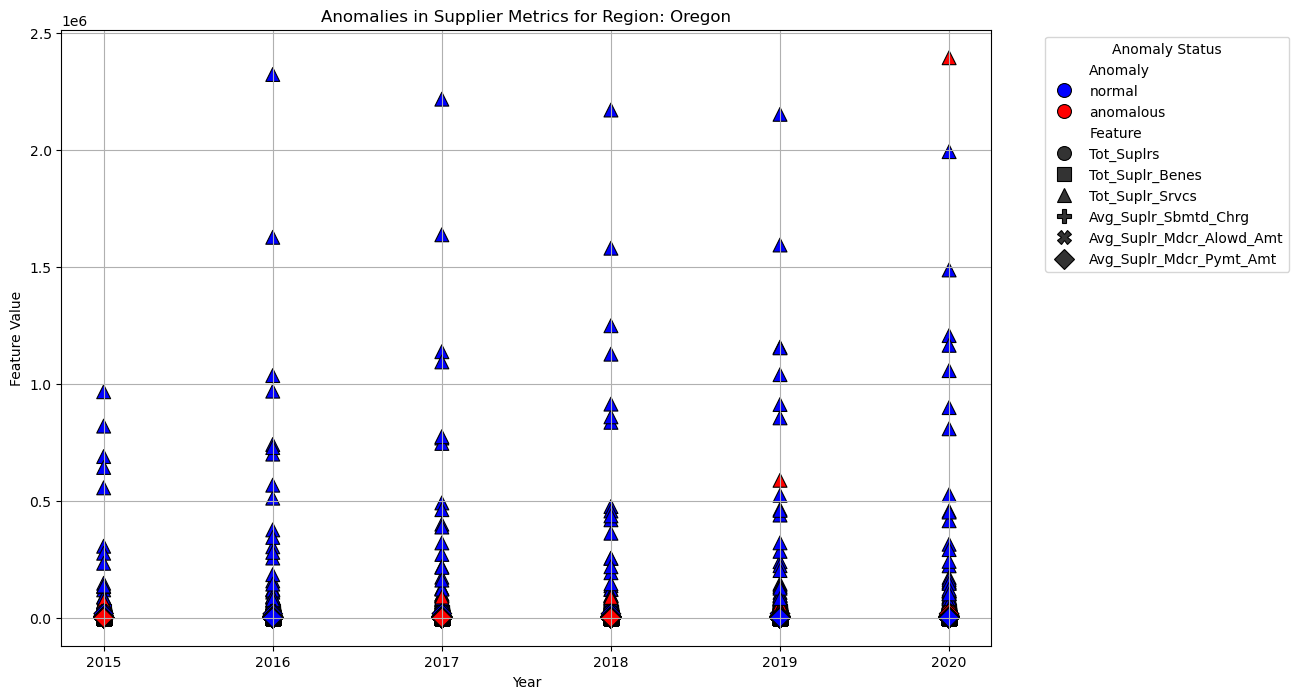

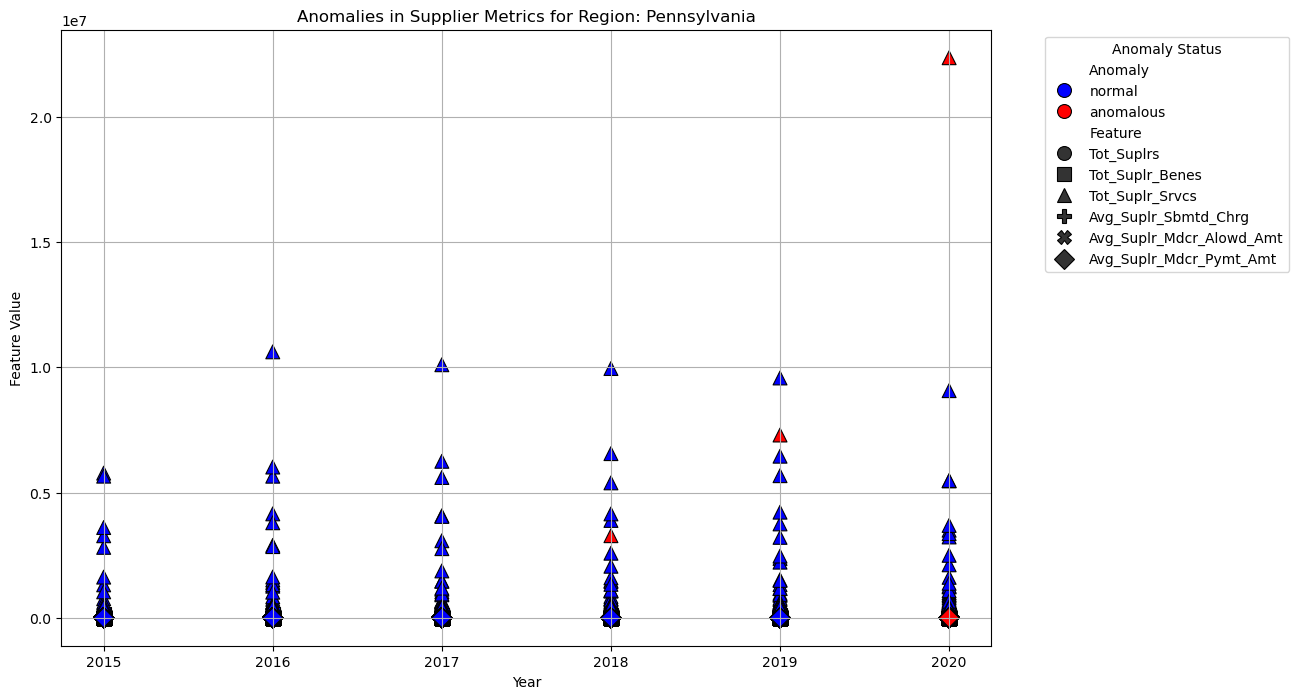

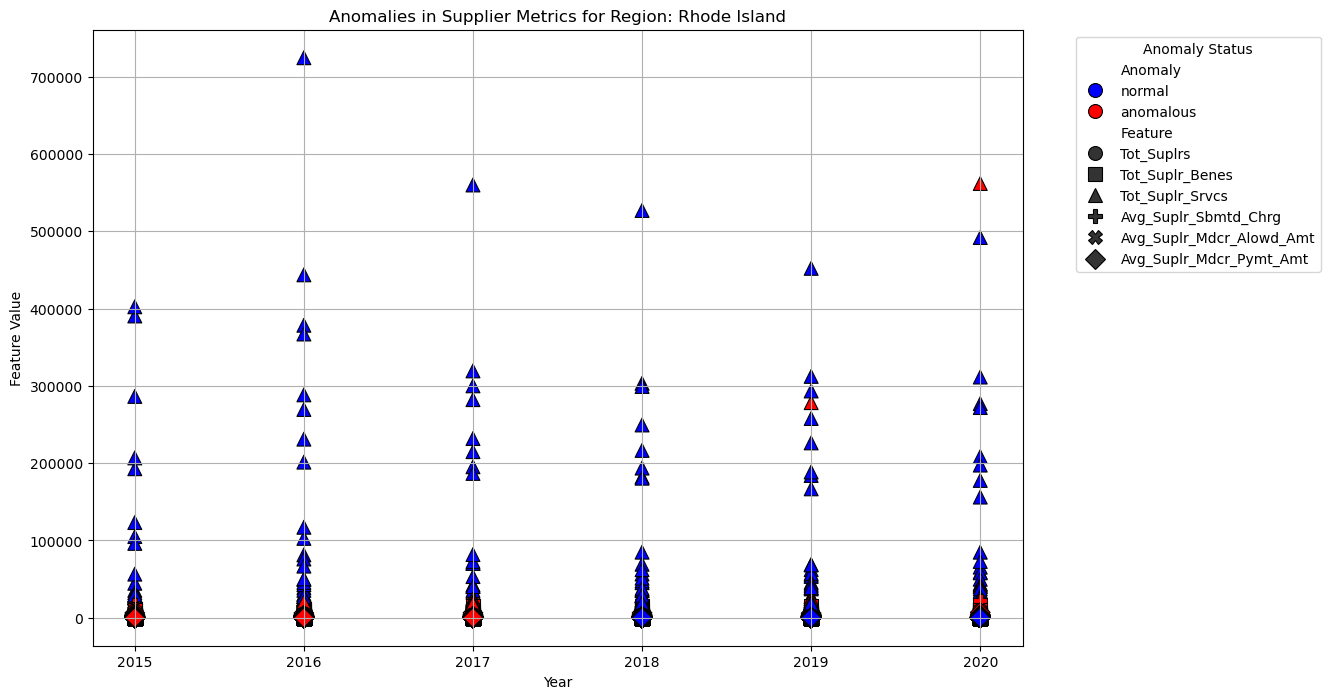

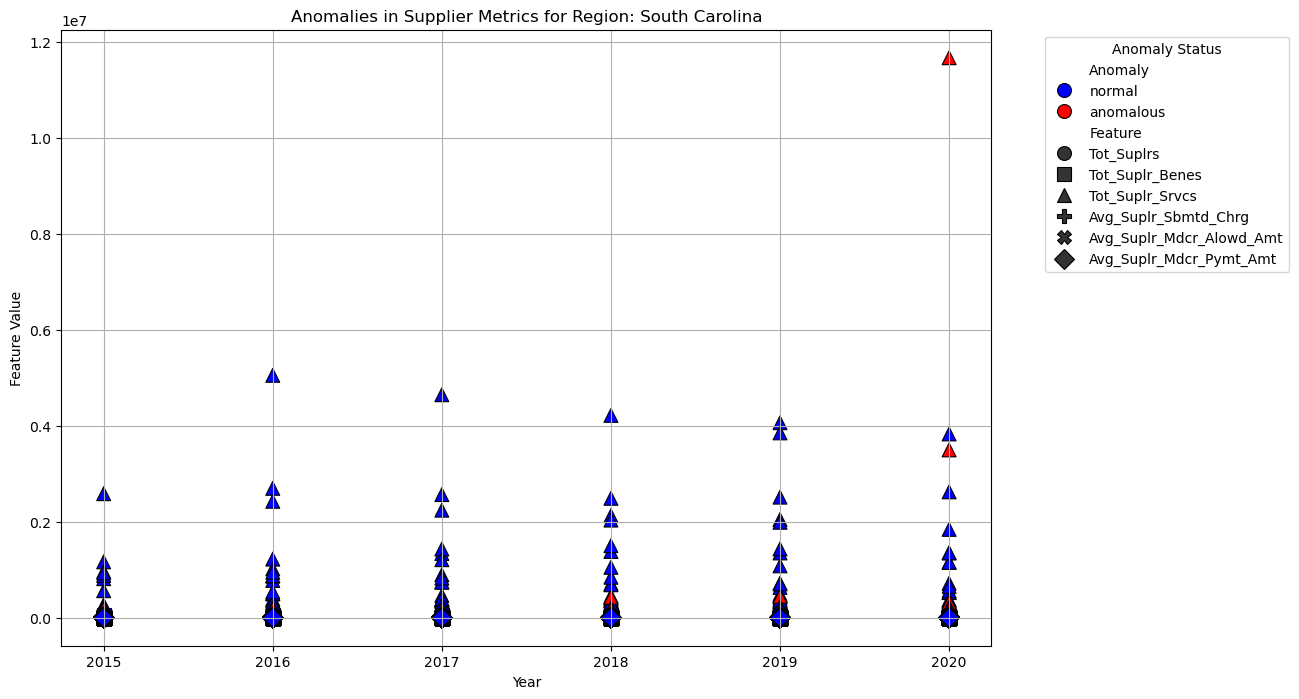

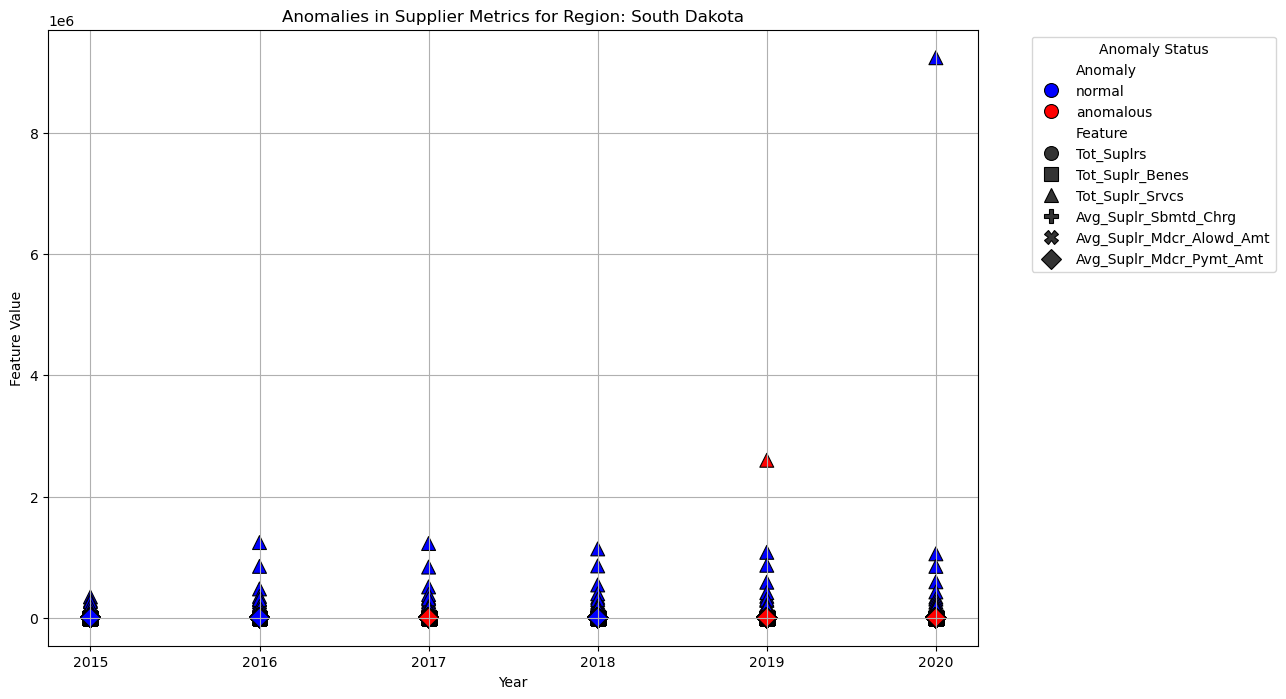

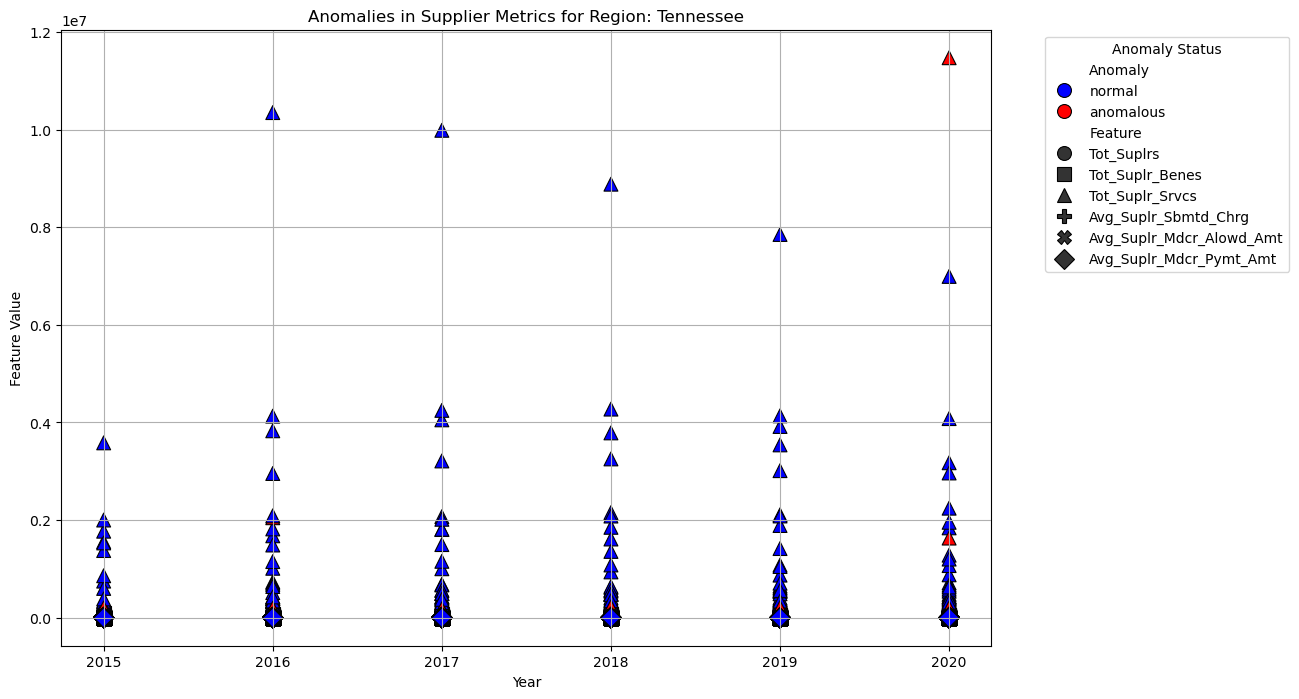

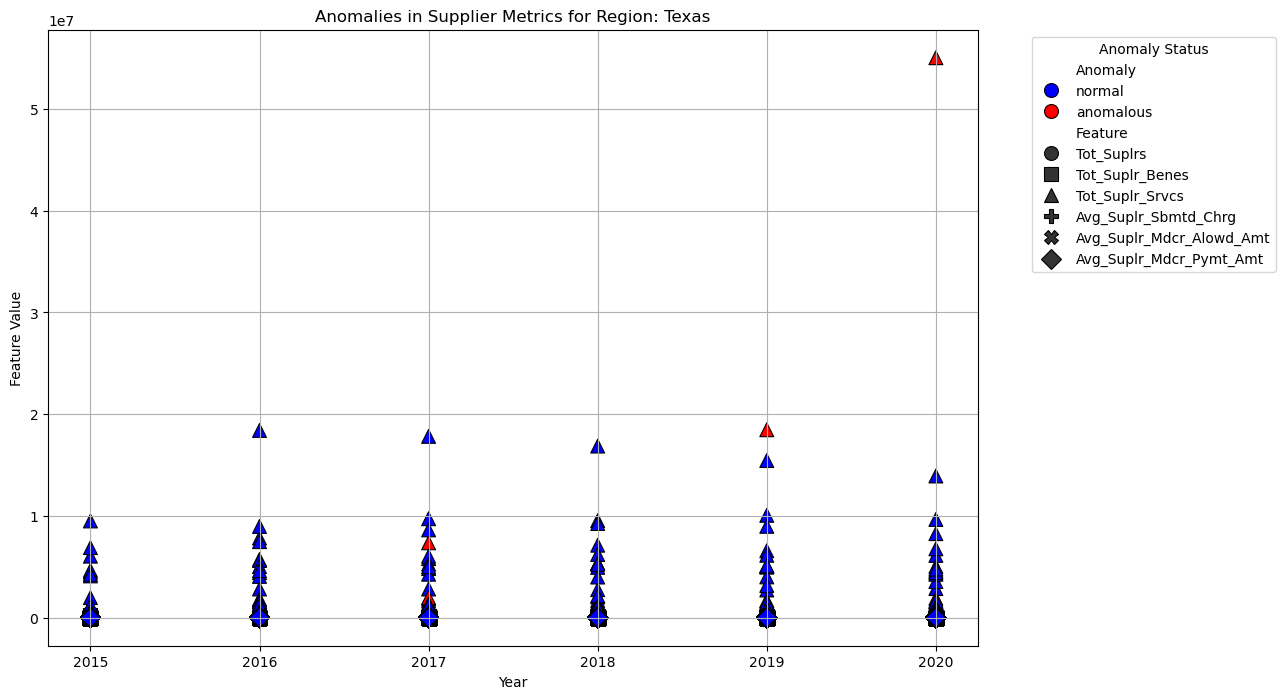

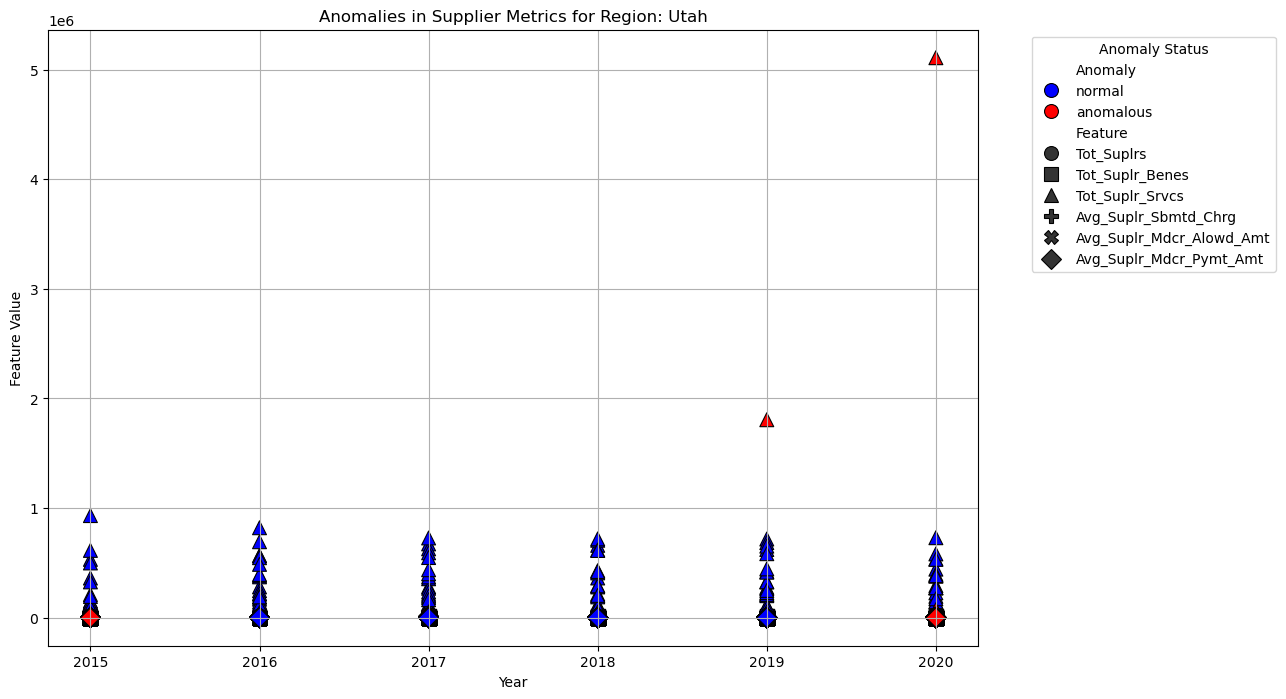

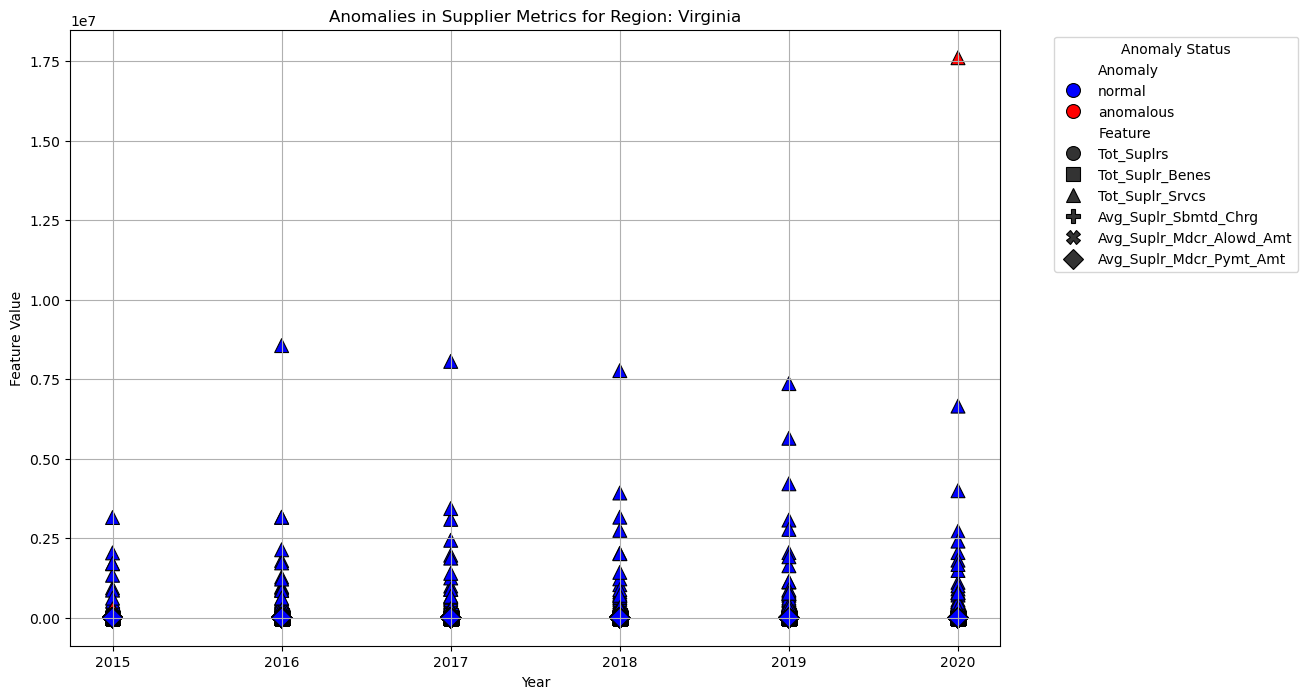

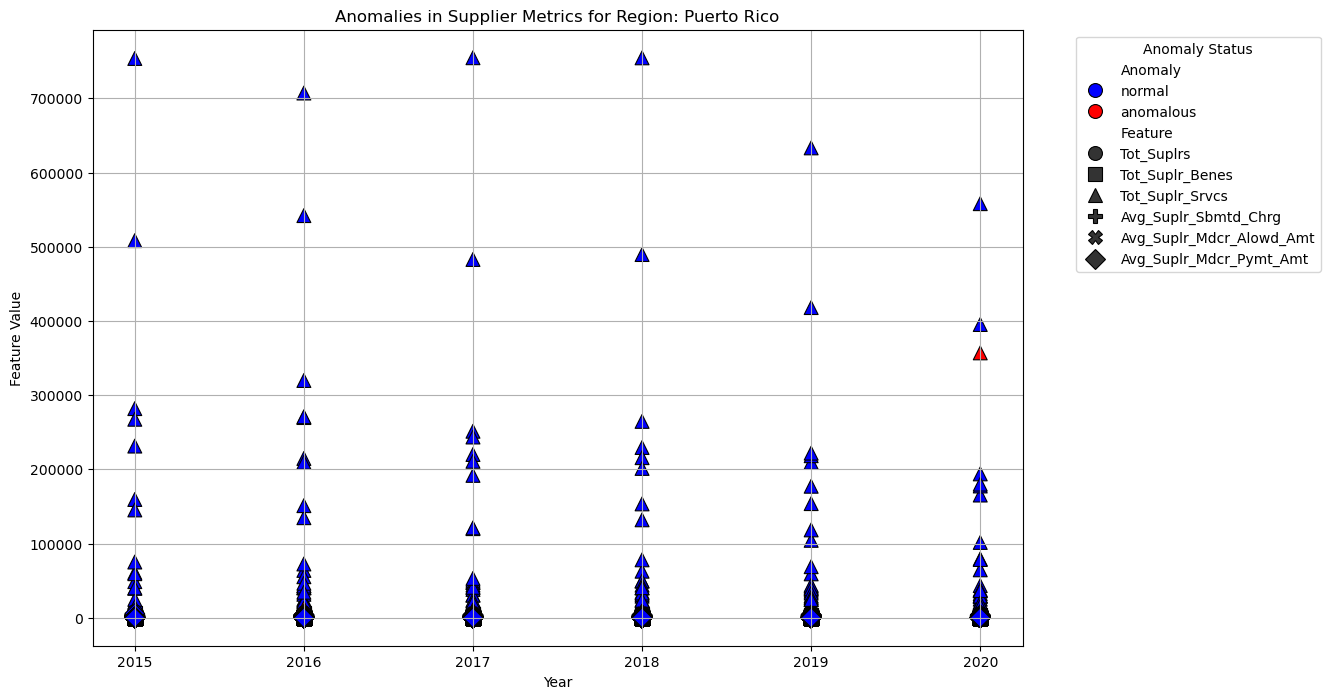

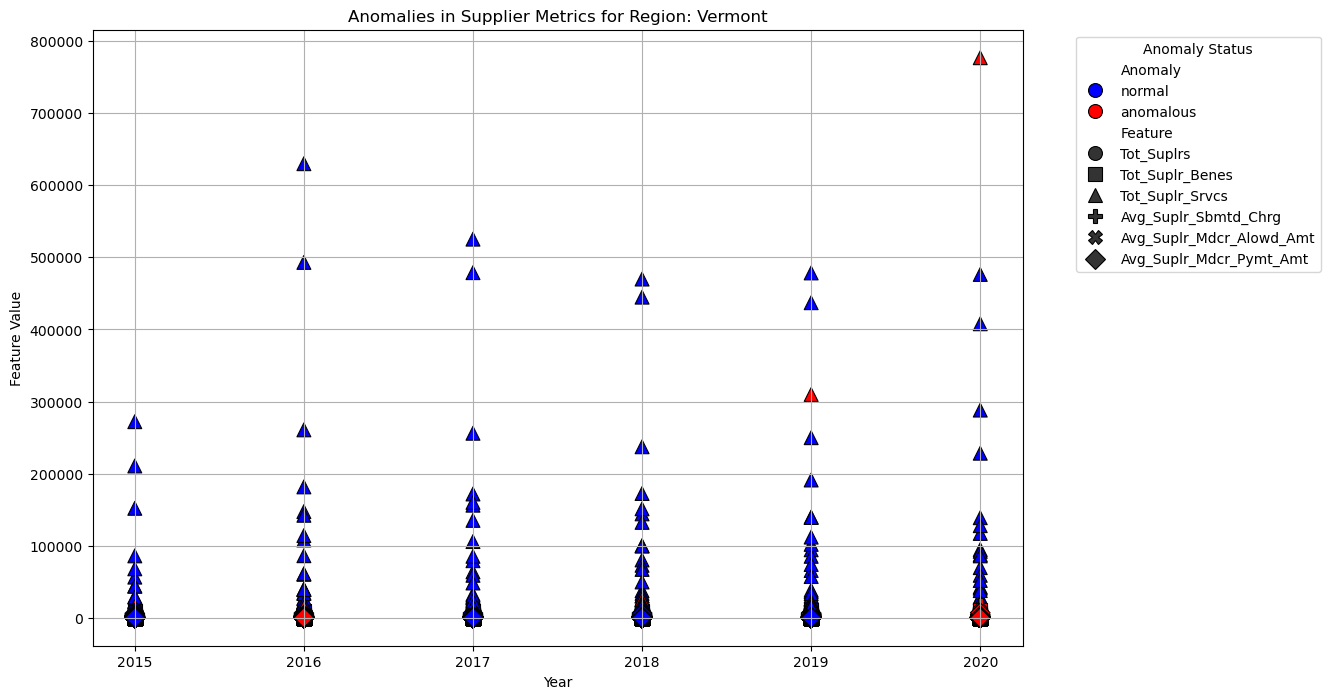

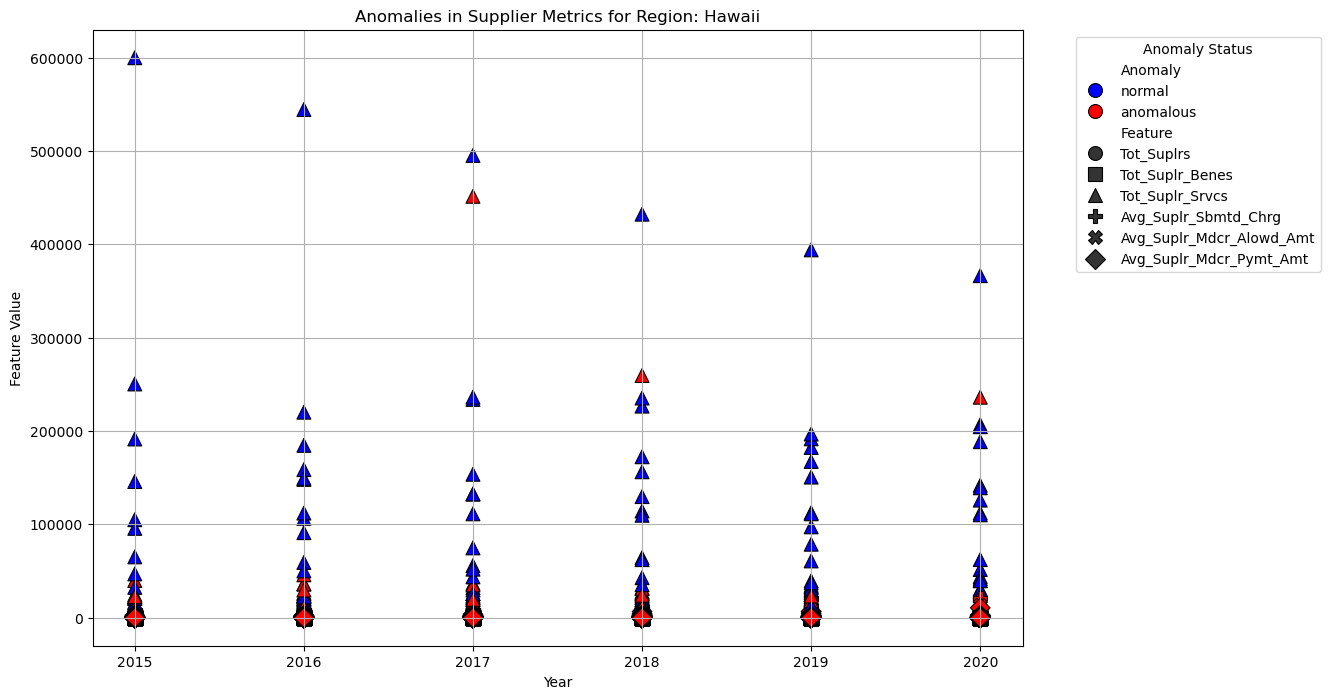

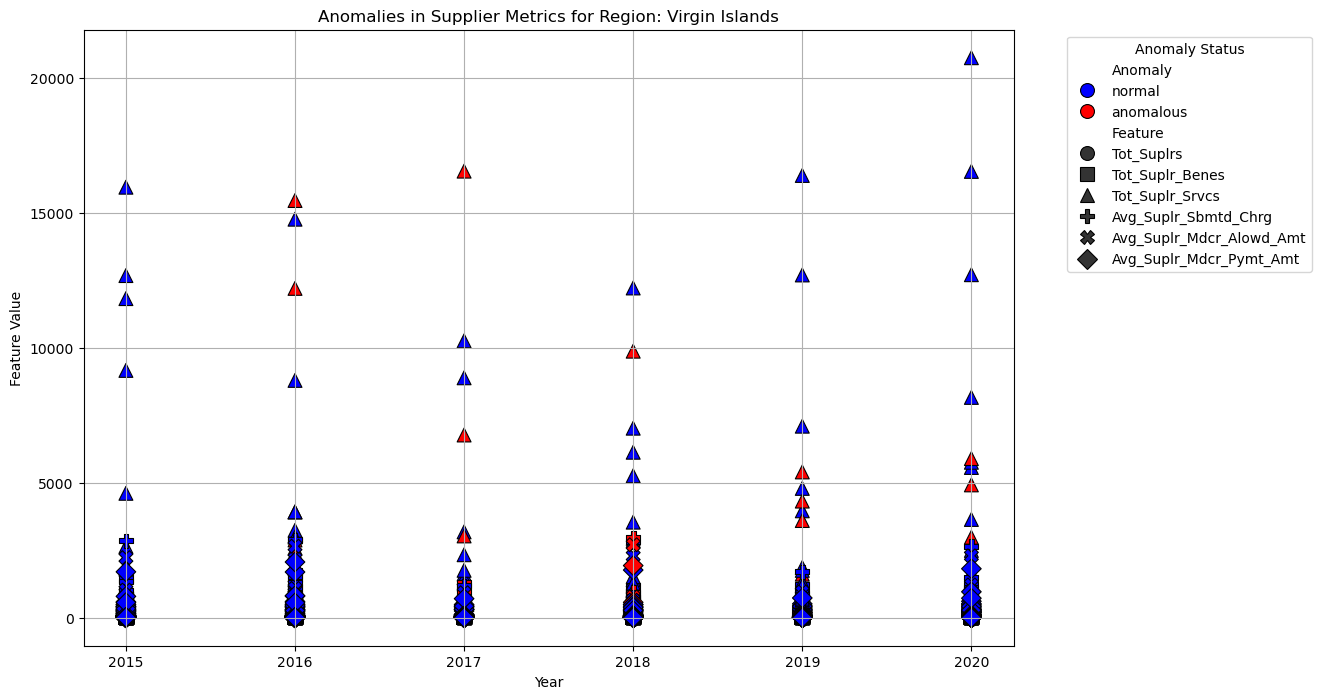

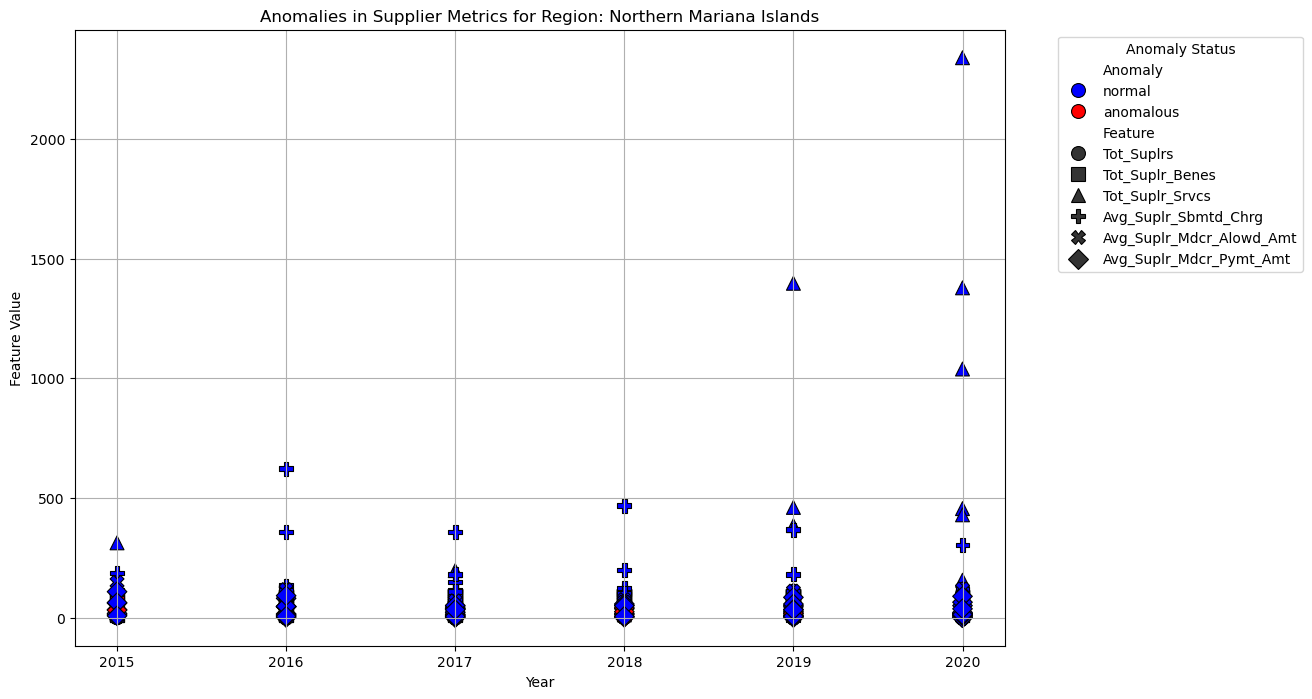

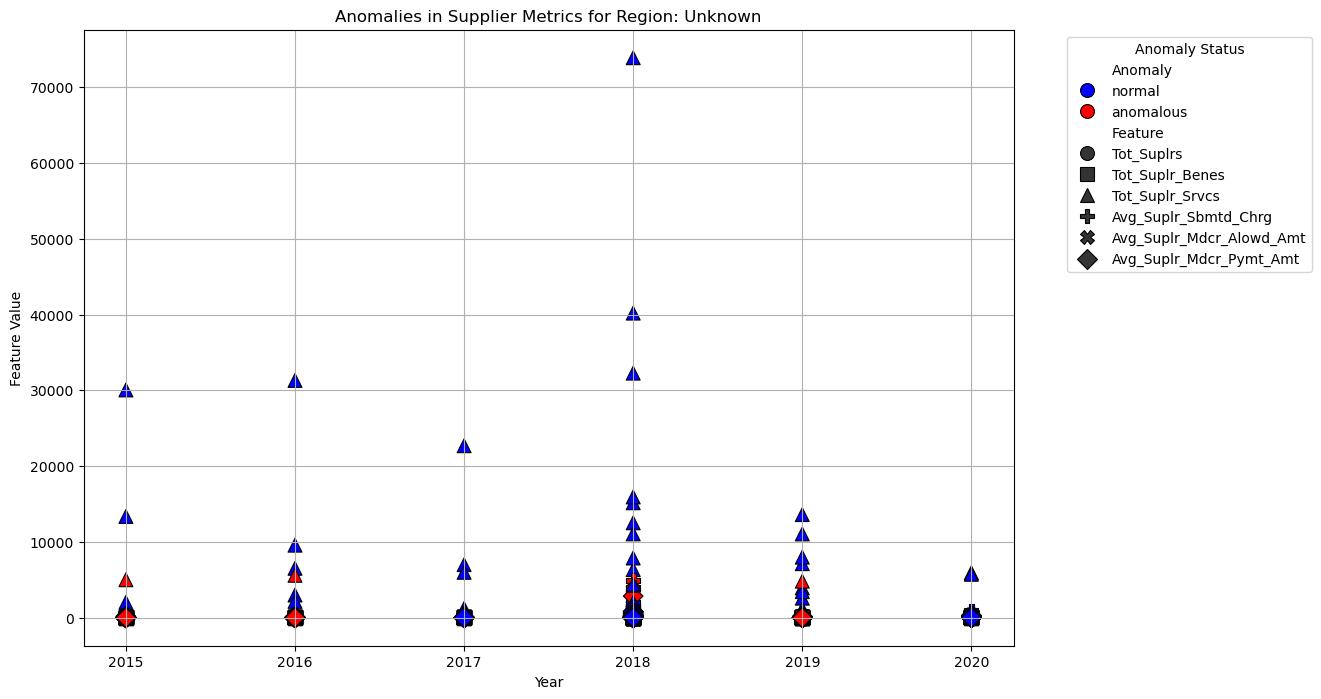

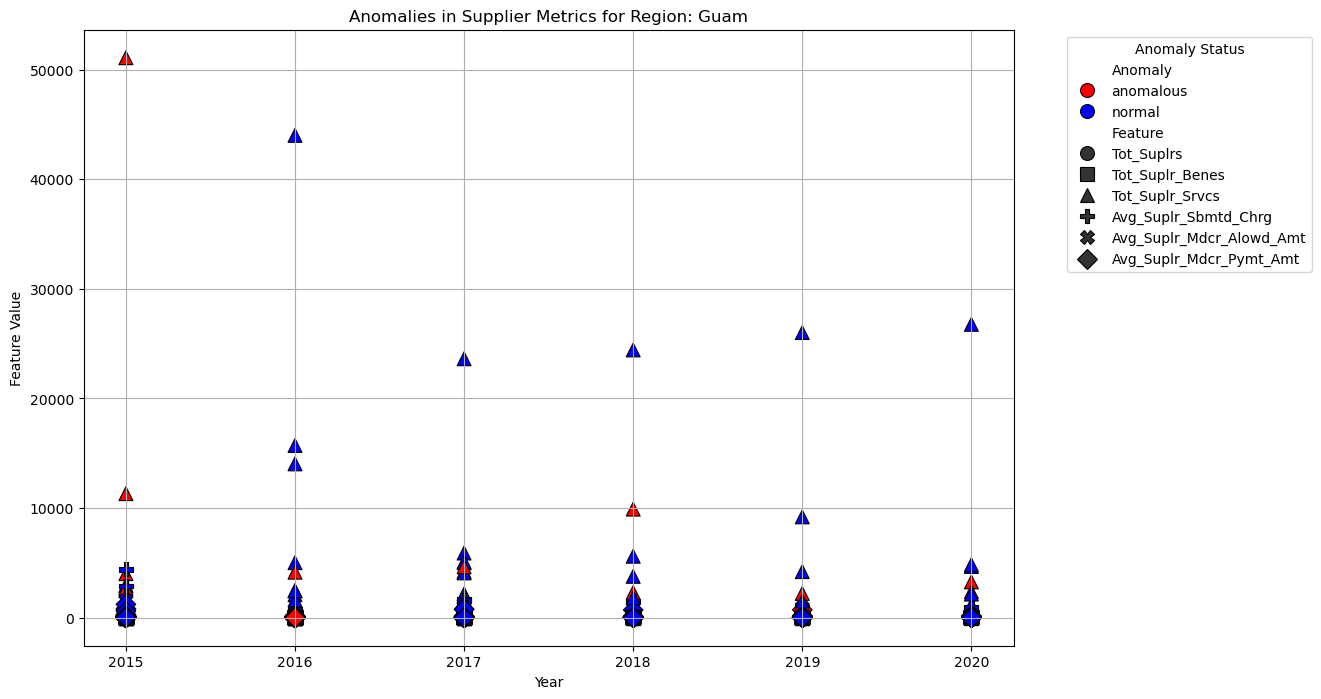

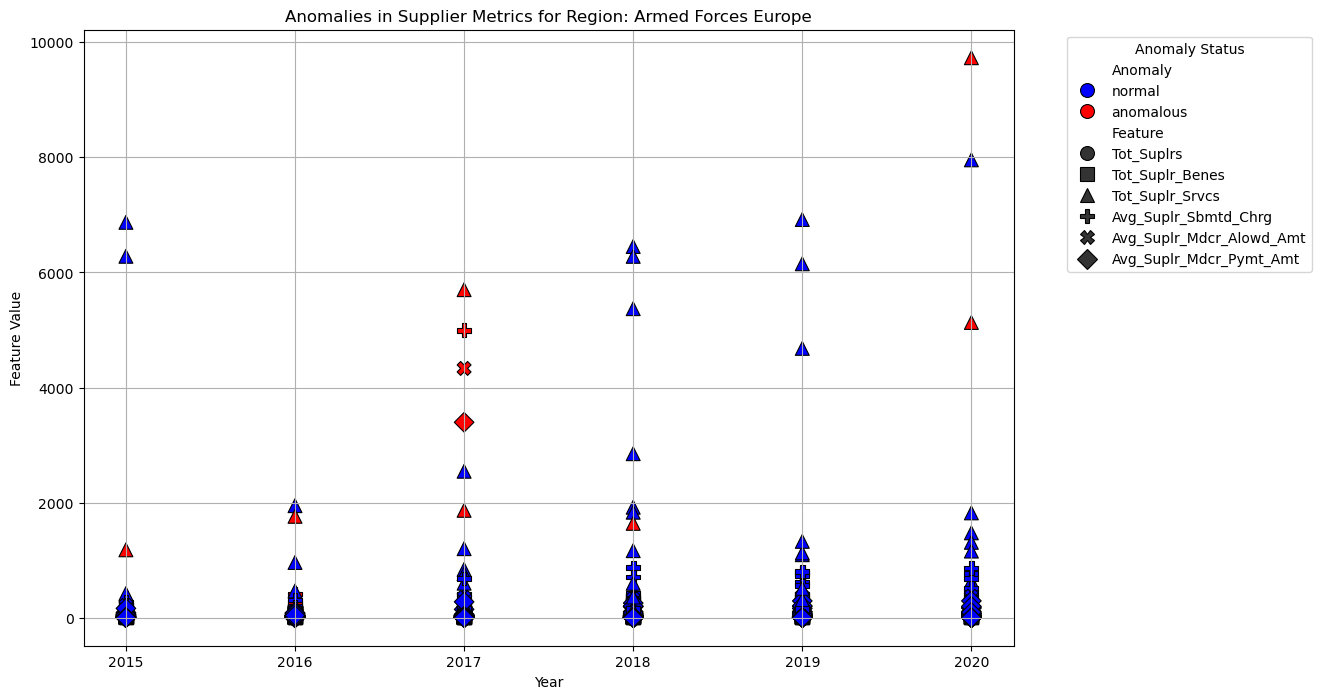

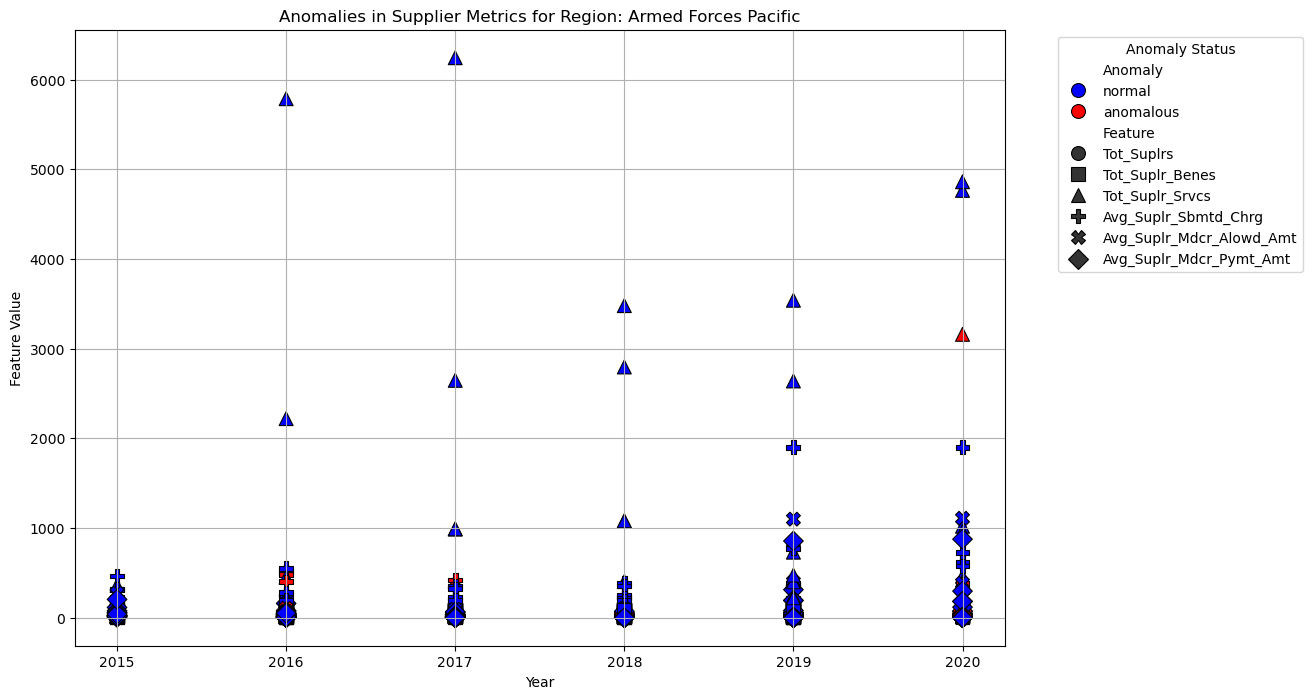

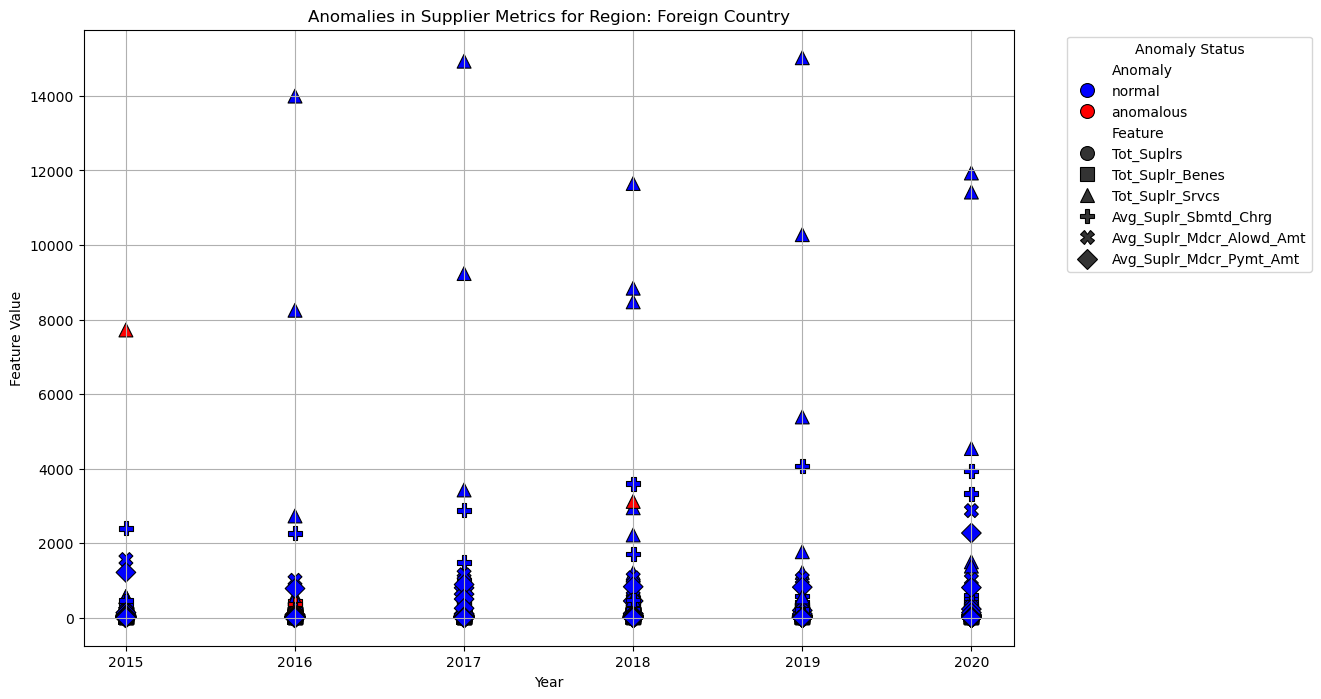

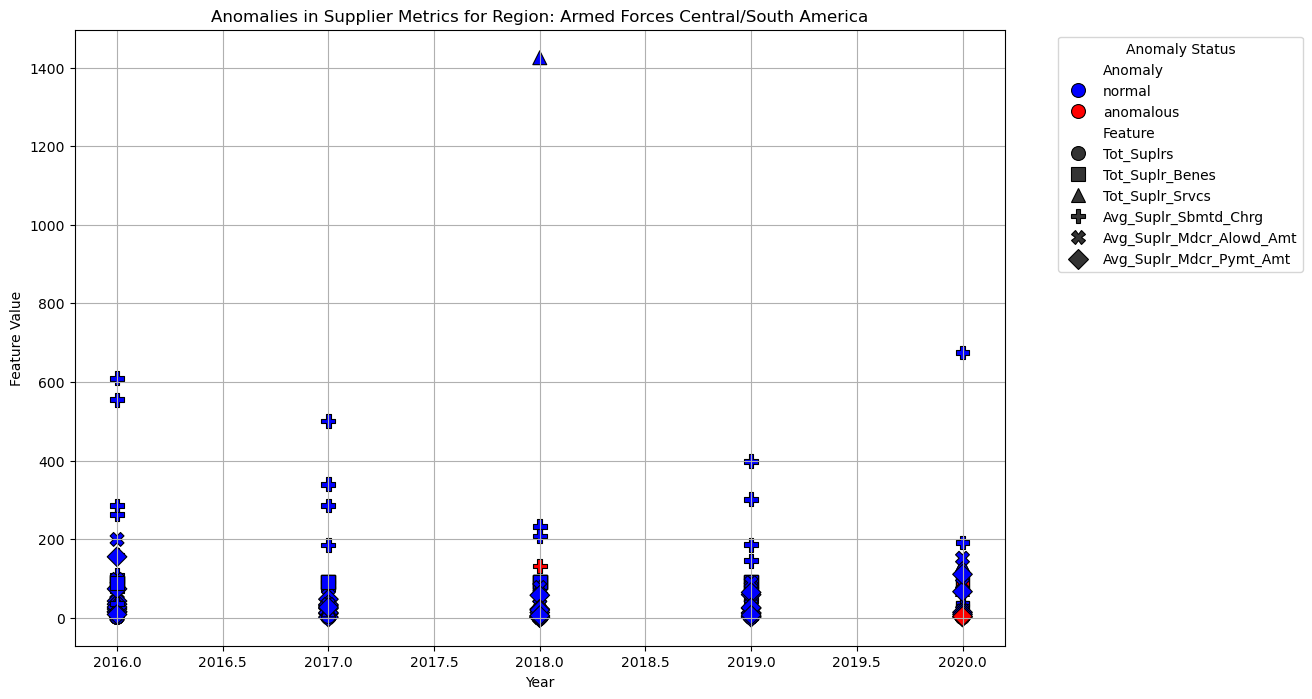

In [7]:
# Define years and regions from the train_data DataFrame
years = train_data['Year']
regions = train_data['Rfrg_Prvdr_Geo_Desc']


# DataFrame to store anomaly labels by year, region, and feature
anomaly_results = pd.DataFrame(columns=['Year', 'Region', 'Feature', 'Value', 'Anomaly'])

# Initialize the LOF model
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)

# Loop through each time-series split for cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    years_test = years.iloc[test_index]
    regions_test = regions.iloc[test_index]
    
    # Fit LOF on the training set
    lof_model.fit(X_train)
    
    # Predict anomalies on the test set
    test_preds = lof_model.predict(X_test)  # Returns 1 (inliers) and -1 (outliers)
    
    # Save results with year, region, feature, and anomaly label
    for idx, feature in enumerate(features):
        fold_results = pd.DataFrame({
            'Year': years_test,
            'Region': regions_test,
            'Feature': feature,
            'Value': X.iloc[test_index, idx],
            'Anomaly': np.where(test_preds == -1, 'anomalous', 'normal')
        })
        anomaly_results = pd.concat([anomaly_results, fold_results])

# Define markers for each feature
markers = {
    'Tot_Suplrs': 'o',
    'Tot_Suplr_Benes': 's',
    'Tot_Suplr_Srvcs': '^',
    'Avg_Suplr_Sbmtd_Chrg': 'P',
    'Avg_Suplr_Mdcr_Alowd_Amt': 'X',
    'Avg_Suplr_Mdcr_Pymt_Amt': 'D'
}

# Plotting anomalies for each region over time, across all features
for region in anomaly_results['Region'].unique():
    region_data = anomaly_results[anomaly_results['Region'] == region]
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=region_data, x='Year', y='Value', hue='Anomaly', style='Feature',
                    palette={'normal': 'blue', 'anomalous': 'red'}, markers=markers, s=100, edgecolor="black")
    
    # Customize plot
    plt.title(f'Anomalies in Supplier Metrics for Region: {region}')
    plt.xlabel('Year')
    plt.ylabel('Feature Value')
    plt.legend(title='Anomaly Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


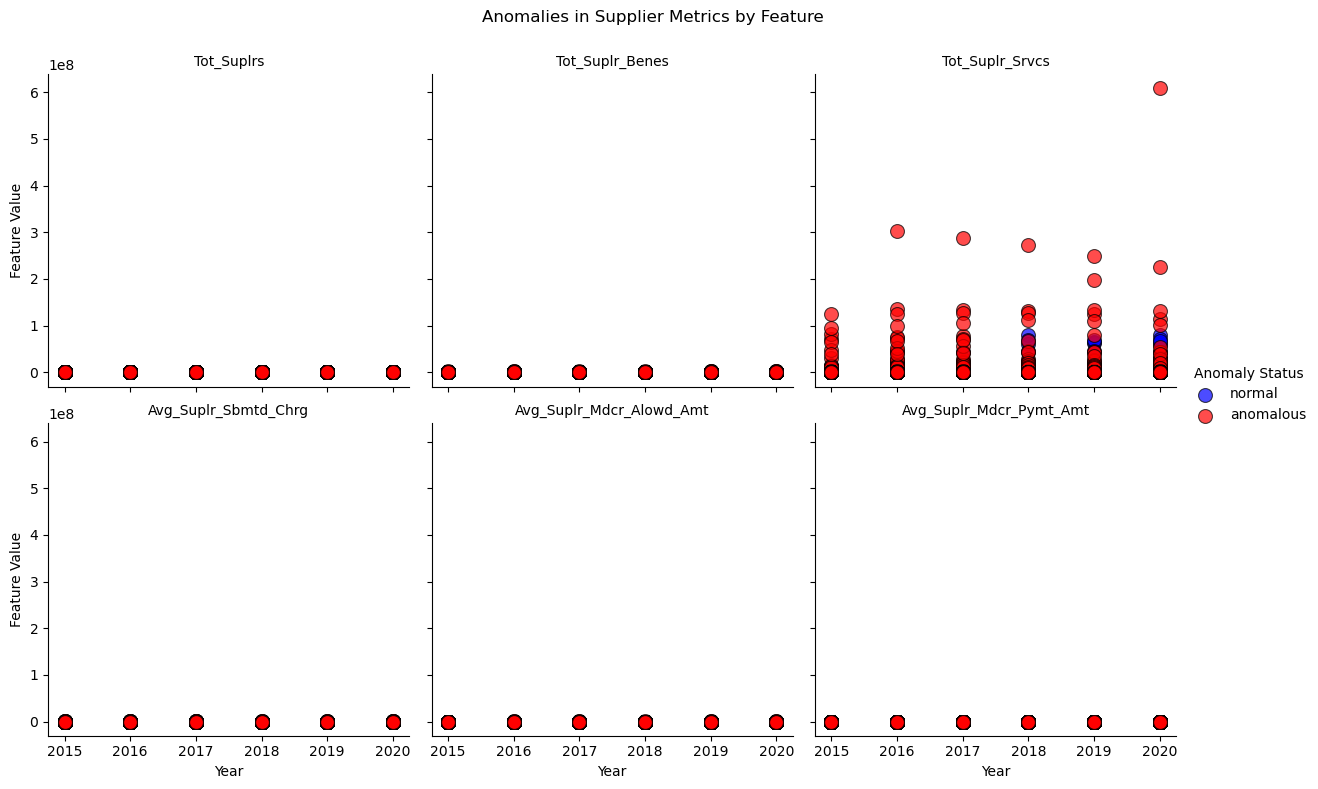

In [8]:

# Plotting anomalies for each region over time, across all features, using FacetGrid
g = sns.FacetGrid(anomaly_results, col='Feature', hue='Anomaly', col_wrap=3, height=4, palette={'normal': 'blue', 'anomalous': 'red'})
g.map(sns.scatterplot, 'Year', 'Value', marker='o', edgecolor="black", s=100, alpha=0.7)

# Customize plot
g.set_axis_labels('Year', 'Feature Value')
g.set_titles("{col_name}")
g.add_legend(title='Anomaly Status')

# Adjust layout and show the plot
plt.subplots_adjust(top=0.9)  # Adjust the top to make space for the titles
g.fig.suptitle('Anomalies in Supplier Metrics by Feature')
plt.show()


## Compute and Plot Temporal Correlations

### Temporal Spearman Correlation Between Service Volumes and Supplier Charges (Train Data)

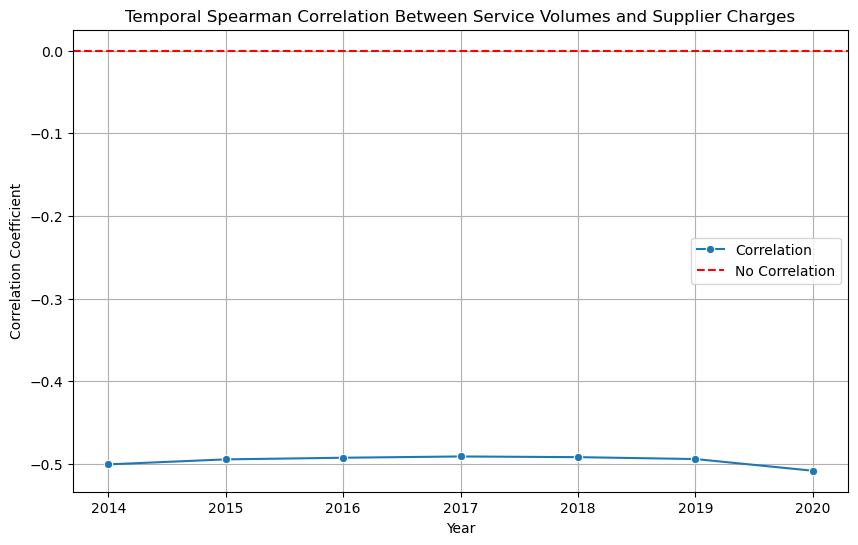

In [9]:
from scipy.stats import spearmanr

# Group data by year and compute Spearman correlation
temporal_correlations = train_data_no_anomalies.groupby('Year').apply(
    lambda df: spearmanr(df['Tot_Suplr_Srvcs'], df['Avg_Suplr_Sbmtd_Chrg']).correlation
).reset_index(name='Correlation')

# Plot temporal correlation trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=temporal_correlations, x='Year', y='Correlation', marker='o', label='Correlation')
plt.axhline(0, color='red', linestyle='--', label='No Correlation')
plt.title('Temporal Spearman Correlation Between Service Volumes and Supplier Charges')
plt.xlabel('Year')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()


### Identification of Anomalous Temporal Correlations (Train Data)

In [10]:
# Define threshold for high/low correlations (you can adjust this)
threshold = 0.5   #  threshold for high correlation

# Identify anomalous periods with correlation above threshold
anomalous_periods = temporal_correlations[temporal_correlations['Correlation'].abs() > threshold]

# Print anomalous periods
print("Anomalous Correlations (By Year):")
print(anomalous_periods)



Anomalous Correlations (By Year):
   Year  Correlation
0  2014    -0.500559
6  2020    -0.508250


### Identification of Regions with Unusual Spearman Correlations (Train Data)

Regions with Unusual Correlations (High or Low):
     Rfrg_Prvdr_Geo_Desc  Spearman_Correlation
1                 Alaska             -0.657651
4               Arkansas             -0.517553
8             California             -0.507716
9               Colorado             -0.506786
10           Connecticut             -0.546687
11              Delaware             -0.586199
12  District of Columbia             -0.594093
17                Hawaii             -0.630017
18                 Idaho             -0.537721
21                  Iowa             -0.540936
22                Kansas             -0.527181
23              Kentucky             -0.500925
24             Louisiana             -0.521905
25                 Maine             -0.581346
26              Maryland             -0.502716
27         Massachusetts             -0.538903
29             Minnesota             -0.513336
32               Montana             -0.562939
34              Nebraska             -0.539999
35         

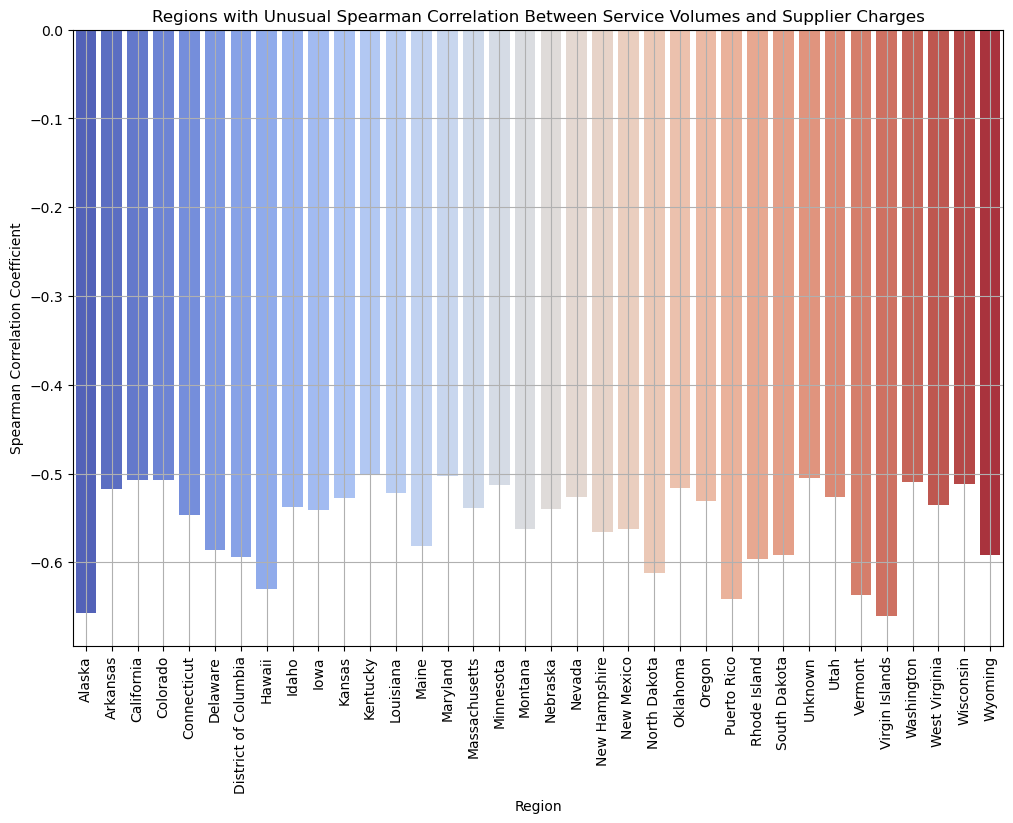

In [11]:
# Group data by region and compute the Spearman correlation for each region
region_correlations = train_data_no_anomalies.groupby('Rfrg_Prvdr_Geo_Desc').apply(
    lambda df: spearmanr(df['Tot_Suplr_Srvcs'], df['Avg_Suplr_Sbmtd_Chrg']).correlation
).reset_index(name='Spearman_Correlation')


# Define threshold for high/low correlations (adjust as needed)
high_threshold = 0.5  # High correlation
low_threshold = -0.5  # Low correlation

# Filter regions with unusual correlations (either high or low)
unusual_regions = region_correlations[
    (region_correlations['Spearman_Correlation'] > high_threshold) |
    (region_correlations['Spearman_Correlation'] < low_threshold)
]

# Display the regions with unusual correlations
print("Regions with Unusual Correlations (High or Low):")
print(unusual_regions)

# Optionally, plot these unusual regions for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=unusual_regions, x='Rfrg_Prvdr_Geo_Desc', y='Spearman_Correlation', palette='coolwarm')
plt.title('Regions with Unusual Spearman Correlation Between Service Volumes and Supplier Charges')
plt.xlabel('Region')
plt.ylabel('Spearman Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### Temporal Spearman Correlation Trends for Unusual Regions

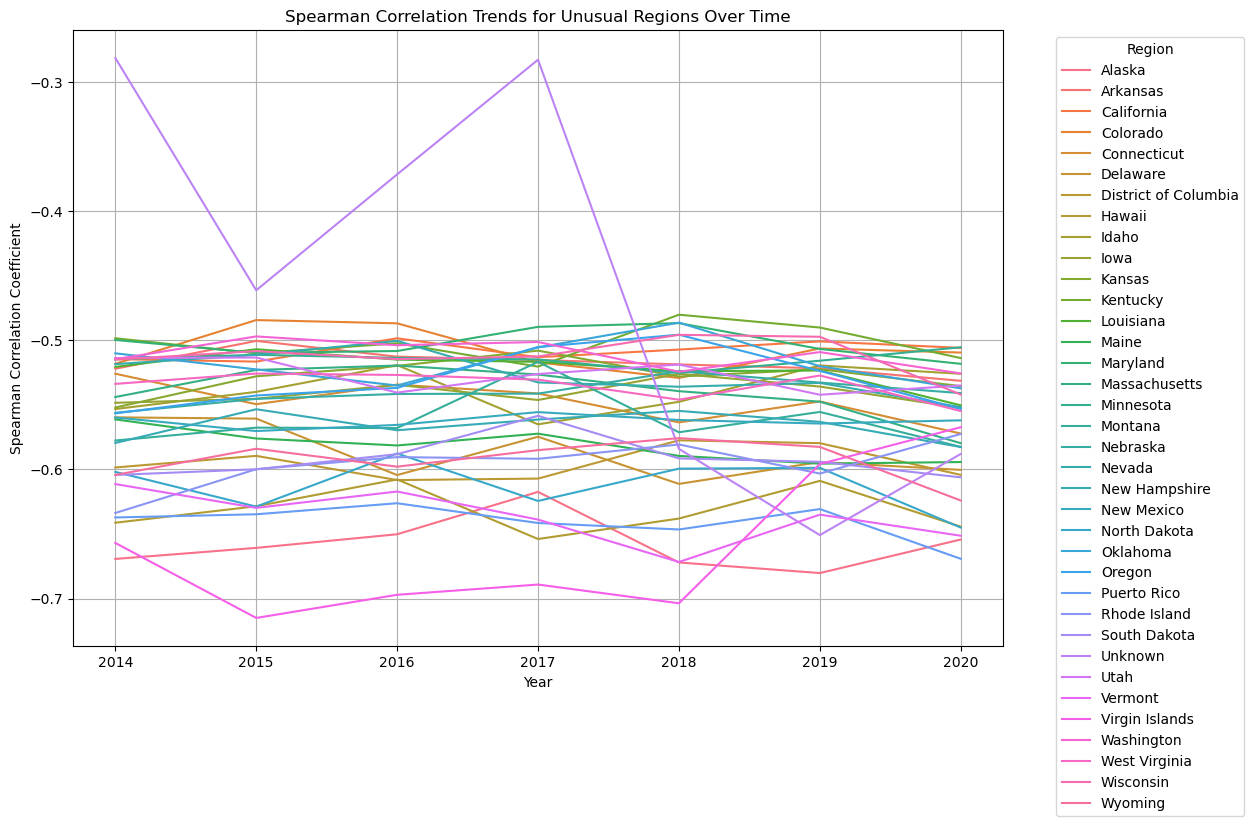

In [12]:
# Filter the original data to focus on the unusual regions
unusual_regions_data = train_data_no_anomalies[train_data_no_anomalies['Rfrg_Prvdr_Geo_Desc'].isin(unusual_regions['Rfrg_Prvdr_Geo_Desc'])]

# Group data by year and region, then compute the Spearman correlation for each region and year
unusual_regions_temporal_correlations = unusual_regions_data.groupby(['Rfrg_Prvdr_Geo_Desc', 'Year']).apply(
    lambda df: spearmanr(df['Tot_Suplr_Srvcs'], df['Avg_Suplr_Sbmtd_Chrg']).correlation
).reset_index(name='Spearman_Correlation')

# Plot the time series of correlations for the unusual regions
plt.figure(figsize=(12, 8))
sns.lineplot(data=unusual_regions_temporal_correlations, x='Year', y='Spearman_Correlation', hue='Rfrg_Prvdr_Geo_Desc')
plt.title('Spearman Correlation Trends for Unusual Regions Over Time')
plt.xlabel('Year')
plt.ylabel('Spearman Correlation Coefficient')
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Temporal Spearman Correlation Between Service Volumes and Supplier Charges (Test Data)

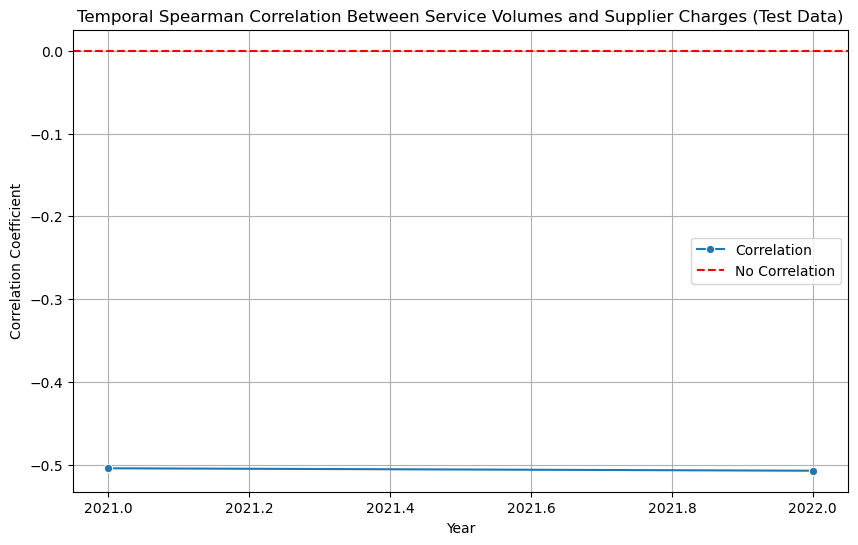

In [13]:
# Compute Spearman correlation for test data
temporal_correlations_test = test_data.groupby('Year').apply(
    lambda df: spearmanr(df['Tot_Suplr_Srvcs'], df['Avg_Suplr_Sbmtd_Chrg']).correlation
).reset_index(name='Correlation')

# Plot and analyze the temporal correlation for test data
plt.figure(figsize=(10, 6))
sns.lineplot(data=temporal_correlations_test, x='Year', y='Correlation', marker='o', label='Correlation')
plt.axhline(0, color='red', linestyle='--', label='No Correlation')
plt.title('Temporal Spearman Correlation Between Service Volumes and Supplier Charges (Test Data)')
plt.xlabel('Year')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()


### Identification of Anomalous Temporal Correlations (Test Data)

In [14]:
# Filter for anomalous correlations in test data
anomalous_periods_test = temporal_correlations_test[temporal_correlations_test['Correlation'].abs() > threshold]
print("Anomalous Correlations (Test Data):")
print(anomalous_periods_test)


Anomalous Correlations (Test Data):
   Year  Correlation
0  2021    -0.504310
1  2022    -0.507253


### Identification of Regions with Unusual Spearman Correlations (Test Data)

Regions with Unusual Correlations (High or Low) in Test Data:
         Rfrg_Prvdr_Geo_Desc  Spearman_Correlation
0                    Alabama             -0.513041
1                     Alaska             -0.621312
3                   Arkansas             -0.548648
8                   Colorado             -0.505690
9                Connecticut             -0.587728
10                  Delaware             -0.585365
11      District of Columbia             -0.618399
13           Foreign Country             -0.551753
16                    Hawaii             -0.592777
17                     Idaho             -0.541072
19                   Indiana             -0.511198
20                      Iowa             -0.561996
21                    Kansas             -0.518565
22                  Kentucky             -0.529673
23                 Louisiana             -0.552382
24                     Maine             -0.561184
25                  Maryland             -0.520266
26             Massa

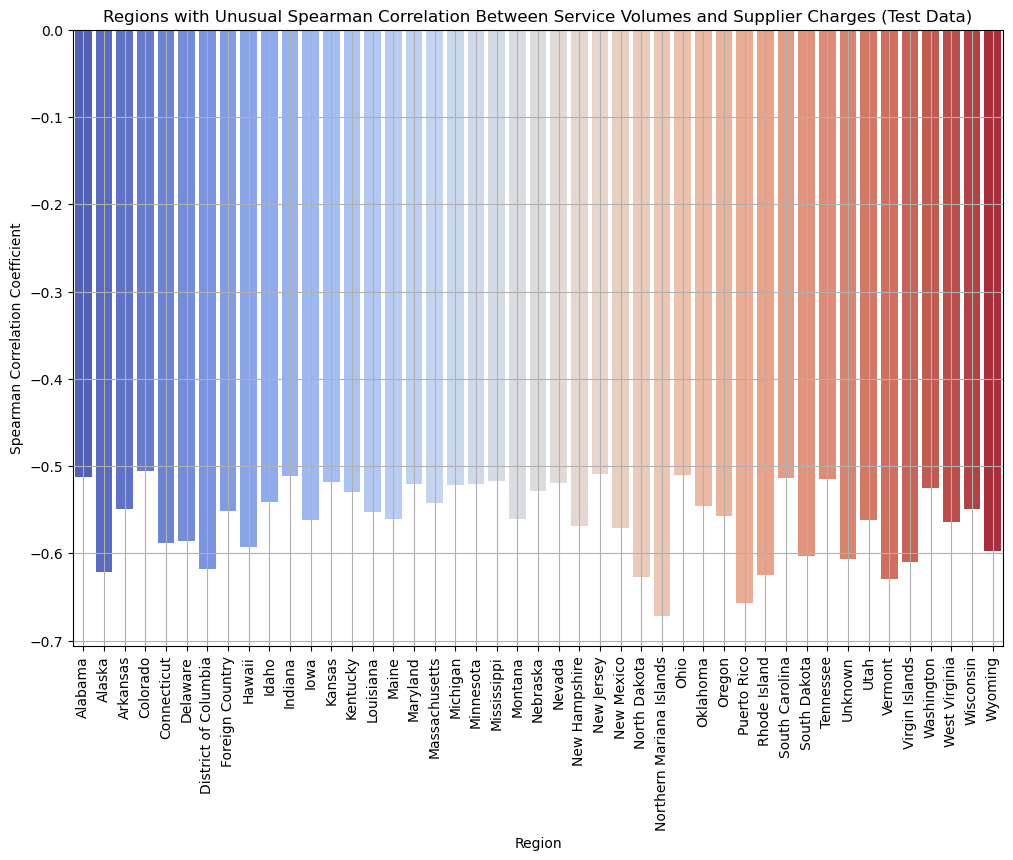

In [15]:
# Group test data by region and compute the Spearman correlation for each region
region_correlations_test = test_data.groupby('Rfrg_Prvdr_Geo_Desc').apply(
    lambda df: spearmanr(df['Tot_Suplr_Srvcs'], df['Avg_Suplr_Sbmtd_Chrg']).correlation
).reset_index(name='Spearman_Correlation')

# Define threshold for high/low correlations (adjust as needed)
high_threshold = 0.5  # High correlation
low_threshold = -0.5  # Low correlation

# Filter regions with unusual correlations (either high or low)
unusual_regions_test = region_correlations_test[
    (region_correlations_test['Spearman_Correlation'] > high_threshold) |
    (region_correlations_test['Spearman_Correlation'] < low_threshold)
]

# Display the regions with unusual correlations
print("Regions with Unusual Correlations (High or Low) in Test Data:")
print(unusual_regions_test)

# Optionally, plot these unusual regions for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=unusual_regions_test, x='Rfrg_Prvdr_Geo_Desc', y='Spearman_Correlation', palette='coolwarm')
plt.title('Regions with Unusual Spearman Correlation Between Service Volumes and Supplier Charges (Test Data)')
plt.xlabel('Region')
plt.ylabel('Spearman Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()
